In [1]:
from __future__ import print_function, division
import os
import sys
import datetime

sys.path.insert(0,os.path.expanduser("deepfish"))
from deepfish.deep_skip import DeepSkip, train
Model = DeepSkip

import torch as T
import torch
import torch.nn.functional as F
import torch.nn as nn
from torchvision.utils import save_image
from torch.utils.data import DataLoader, Dataset
import scipy.linalg
from functools import partial
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec
import scipy.sparse as sparse
from scipy import stats
import gc
from tqdm import tqdm
import pandas as pd
import seaborn as sb
from pandas import DataFrame
from scipy.spatial import distance
from scipy.cluster import hierarchy
from torchvision.transforms import Resize
import dill
from joblib import Parallel, delayed
import cv2
import resource
import torch.nn as nn
import math
import torch.utils.model_zoo as model_zoo
# import apex # https://github.com/NVIDIA/apex.git
# from apex.amp import amp


import os, sys, datetime
import itertools
# LF_CODE_PATH = os.path.expanduser('~/projects/LFAnalyze/code')
# FT_CODE_PATH = os.path.expanduser('~/projects/fishTrax/code/analysis/')
# FD_CODE_PATH = os.path.expanduser('~/projects/fish_despair_notebooks/src/')
# sys.path.insert(0,LF_CODE_PATH)
# sys.path.insert(0,FT_CODE_PATH)
# sys.path.insert(0,FD_CODE_PATH)

# import passivity_2p_imaging_utils as p2putils
# reload(p2putils)
tmp_dir = '/tmp/'
# all_data = p2putils.get_all_datasets(tmp_dir=tmp_dir)

# sys.path.insert(0,".")
from deepfish.helpers import get_frames_from_z, get_imaging_from_fish, gen_imaging, resize_volume, resize_batch, read_cnmf, no_overlap_idx, train_valid_test_split, train_test_split, pad_imaging

from deepfish.stats import sampleMSE
from deepfish.plot import interpret, plot_model_vs_real, makePredVideo, MSEbyDist

from deepfish.data import ZebraFishData
# from deepfish.deep_kSVD import Deep_KSVD, train
from deepfish.half_precision import network_to_half

T.backends.cudnn.benchmark = True

# PARAMETERS
gen = False
# gen = True
cuda=True
# cnmf=True
cnmf=False
half=True
half=False
multi_gpu = True
num_workers = 16
prev_frames = 5
next_frames = 5
kl_lambda = 5e-4
sparse_lambda=1e-3
lr=1e-3
nepochs = 11
nEmbedding = 20
# batch_size = 6
batch_size = 32

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))


In [2]:
class ZebraFishDataRNA(Dataset):
    "B x nFrames x Z x H x W"
    def __init__(self, imaging, structural, shocks, tail_movements,
                 index_map=None, prev_frames=2, next_frames=1):
        data = imaging - imaging.mean(0)
        # use channel for future / prev frames
        self.data = T.from_numpy(data)
        self.prev_frames = prev_frames
        self.next_frames = next_frames
        self.shocks = shocks
        self.tail_movements = tail_movements
        self.index_map = index_map
        self.structural = structural

    def __len__(self):
        if self.index_map:
            return len(self.index_map)
        else:
            return self.data.shape[0]-self.prev_frames - self.next_frames + 1

    def __getitem__(self, i):
        "X[0]==X_i, X[1]==X_i-1, Y[0]==Y_i+1, Y[1]==Y_i+2"
        if self.index_map:
            idx = self.index_map[i]
        else:
            idx = i + self.prev_frames - 1 # avoid wraparound
        X = {"brain": [], "shock": [], "tail_movement": []}
        Y = {"brain": [], "shock": [], "tail_movement": []}
        for i in reversed(range(self.prev_frames)):
            ix = idx-i
            X["brain"].append(self.data[ix])
            X["shock"].append(self.shocks[ix])
            X["tail_movement"].append(self.tail_movements[ix])
        for i in range(1,self.next_frames+1):
            ix = idx+i
            Y["brain"].append(self.data[ix])
            Y["shock"].append(self.shocks[ix])
            Y["tail_movement"].append(self.tail_movements[ix])
        for s in structural:
            X["brain"].append(s)
        X = {k: T.stack(v,0) for k,v in X.items()}
        Y = {k: T.stack(v,0) for k,v in Y.items()}
        return X, Y


In [3]:
from tifffile import imread
from glob import glob
import re

In [4]:
directory = "/data2/Data/f10542/small/"

In [5]:
get_num = re.compile(".*_zplane=(\d*).npy")
get_z = lambda x: int(get_num.search(x).group(1))
# planes = glob(directory+"functional*.npy")
structural = glob(directory+"*.npy")
structural = list(filter(lambda x: get_num.match(x) is None, structural))
# planes = sorted(planes, key=lambda a: get_z(a))
# nZ = len(planes)
# print(f"Number of planes: {nZ}")
structural

['/data2/Data/f10542/small/functional.npy',
 '/data2/Data/f10542/small/isosbestic_gcamp.npy',
 '/data2/Data/f10542/small/postfix_gcamp.npy',
 '/data2/Data/f10542/small/postfix_gad.npy',
 '/data2/Data/f10542/small/postfix_vglut.npy']

In [6]:
imaging = np.load(directory+"functional.npy")
isosbestic_gcamp = np.load(structural[1])
postfix_gcamp = np.load(structural[2])
postfix_gad = np.load(structural[3])
postfix_vglut = np.load(structural[4])

structural = T.from_numpy(np.stack([isosbestic_gcamp, postfix_gcamp, postfix_gad, postfix_vglut]))
structural.shape

torch.Size([4, 29, 256, 256])

In [7]:
mean_frame = imaging.mean(0)

nT, nZ, H, W = imaging.shape
nT, nZ, H, W

(5437, 29, 256, 256)

In [8]:
shocks = T.from_numpy(np.zeros(nT).astype(np.float32))
tail_movements = T.from_numpy(np.zeros(nT).astype(np.float32))

In [9]:
# tvt_split = train_valid_test_split(2826, nchunks=20)
tvt_split = train_test_split(nT, nchunks=20)
total_examples = sum([len(x) for x in tvt_split.values()])
print(["{}: {} ({:.2f}%)".format(k, len(v), 100*len(v)/total_examples) for k,v in tvt_split.items()])


# LOAD TIFF
train_data = ZebraFishDataRNA(imaging,structural, shocks,tail_movements,
                        tvt_split['train'], prev_frames,next_frames)

# valid_data = ZebraFishData(imaging,shocks,tail_movements,
#                         tvt_split['validation'], prev_frames,next_frames)

# test_data = ZebraFishDataRNA(imaging,structural,shocks,tail_movements,
test_data = ZebraFishData(imaging,shocks,tail_movements,
                        tvt_split['test'], prev_frames,next_frames)

# all_data = ZebraFishData(imaging,shocks,tail_movements,None,
#                         prev_frames,next_frames)

_, nZ, H, W = train_data[0][0]["brain"].shape


# print("Number of tail movements in test: {}".format(np.array([float(x[1]["tail_movement"]) for x in test_data]).sum()))


# print("len(train_data): {}".format(len(train_data)))

# print("len(test_data): {}".format(len(test_data)))

['train: 4868 (96.05%)', 'validation: 0 (0.00%)', 'test: 200 (3.95%)']


In [10]:
del imaging

In [11]:
gc.collect()

22

In [12]:
from __future__ import print_function, division
import torch as T
import torch.nn as nn
import torch.nn.functional as F
from volume import Vol2D
from resnet import ResNet, BasicBlock
from super_res import SuperResSkip
from torch.utils.data import DataLoader, Dataset
from misc import sigmoid_schedule
from tqdm import tqdm



class DeepSkip(Vol2D):
    def __init__(self, nZ=11, H=232, W=512, nEmbedding=20, prev_frames=1, next_frames=1,
                 pred_hidden=20, tensor=T.cuda.FloatTensor):
        super(DeepSkip, self).__init__(tensor)
        self.tensor = tensor
        self.nZ = nZ
        self.H = H
        self.W = W
        self.lowH = 16
        self.lowW = 16
        self.lowFeatures = 1
        self.prev_frames = prev_frames
        # batch x channel x Z x H x W
        # Encoding
        self.resnet = ResNet(BasicBlock, [2, 2, 2, 2], prev_frames)
        self.resOut = 64
        self.nEmbedding = nEmbedding
        assert nEmbedding % 2 == 0

        # b x 11 x 32 x 11 x 25
        self.encoding_mean = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.encoding_logvar = nn.Linear(self.resOut*self.nZ, nEmbedding)
        self.nhalf_embed = int(self.nEmbedding/2)
        # Prediction
        self.pred1 = nn.Linear(self.nhalf_embed+next_frames, pred_hidden) # add dim for shock_{t+1}
        self.pred2 = nn.Linear(pred_hidden, self.nhalf_embed) # last 10 (context) are unused

        # Prediction
        self.predz1 = nn.Linear(self.nhalf_embed+next_frames, pred_hidden) # add dim for shock_{t+1}
        self.predz2 = nn.Linear(pred_hidden, self.nhalf_embed) # last 10 (context) are unused

        # Decoding
        self.activation = nn.Tanh()
        # only use 10 embeddings for frame decoding, the other 10 are context
        self.decoding = nn.Linear(self.nhalf_embed,self.lowFeatures*nZ*self.lowH*self.lowW)
        self.upconv1 = SuperResSkip(2,65,tensor)
        # 11 x 16 x 32
        self.upconv2 = SuperResSkip(2,65,tensor)
        # 11 x 32 x 64
        self.upconv3 = SuperResSkip(2,65,tensor)
        # 11 x 64 x 128
        self.upconv4 = SuperResSkip(2,65,tensor)
        # 11 x 128 x 256
#         self.upconv5 = SuperResSkip(2,tensor)
        # 11 x 256 x 512

        self.tail_decoding = nn.Linear(1,1)

        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_normal_(self.encoding_mean.weight)
        # TODO - make larger?
        nn.init.xavier_normal_(self.encoding_logvar.weight,1e-3)

    def sample_embedding(self, mu, logvar):
        if self.training:
            std = T.exp(0.5*logvar)
            eps = T.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def encode(self, x):
        x = x.transpose(1,2)
        # X :: b x z x t x h x w
        out = self.tensor(x.shape[0],x.shape[1],self.resOut)
        layers = ["conv1_out", "layer1_out", "layer2_out", "layer3_out", "layer4_out"]
        layer_outputs = {k: [] for k in layers}
        for z in range(x.shape[1]):
            out[:,z], layer_out = self.resnet(x[:,z])
            for k in layers:
#                 print("layer_out "+k+" shape: "+ str(layer_out[k].shape))
                layer_outputs[k].append(layer_out[k])
        layer_outputs = {k: T.stack(v,1) for k,v in layer_outputs.items()}
        mean = self.encoding_mean(out.reshape(x.shape[0],-1))
        logvar = self.encoding_logvar(out.reshape(x.shape[0],-1))
        return mean, logvar, layer_outputs

    def predict(self, x, shock):
        x = T.cat([x, shock],1)
        x = self.activation(self.pred1(x))
        x = self.pred2(x)
        return x

    def predictZero(self, x, shock):
        x = T.cat([x, shock],1)
        x = self.activation(self.predz1(x))
        x = self.predz2(x)
        return x

    def decode(self, x, layer_output):
        tail = T.sigmoid(self.tail_decoding(x[:,[0]])) # use first embedding only
#         tail = F.sigmoid(self.tail_decoding(x[:,[0]])) # use first embedding only
        # b x 10
        # only use first half for brain data
        x = self.activation(self.decoding(x[:,:int(self.nEmbedding/2)]))
        x = x.reshape(x.shape[0],self.nZ,self.lowFeatures,self.lowH,self.lowW)
#         print("upconv1", x.shape)
        x = self.upconv1(x, layer_output["layer3_out"])
#         print("upconv2", x.shape)
        x = self.upconv2(x, layer_output["layer2_out"])
#         print("upconv3", x.shape)
        x = self.upconv3(x, layer_output["layer1_out"])
#         print("upconv4", x.shape)
        x = self.upconv4(x, layer_output["conv1_out"])
#         x = self.upconv5(x)
        x = self.crop(x[:,:,0])
        # squeeze channel
        return x, tail

    def forward(self, x, shock):
        "Return Previous volume (denoised), next volume (prediction), latent mean and logvar."
        mean, logvar, layer_outputs = self.encode(x)
        encoded = self.sample_embedding(mean, logvar)
        encoded_prev = self.predictZero(encoded[:,self.nhalf_embed:], shock)
        encoded_pred = self.predict(encoded[:,:self.nhalf_embed], shock)
        prev = self.decode(encoded_prev, layer_outputs) # force to use only skip connections for decode
        pred = self.decode(encoded_pred, layer_outputs)
        return prev, pred, mean, logvar # should we move variational layer? or return encoded_pred?

def unit_norm_KL_divergence(mu, logvar):
    "Reconstruction + KL divergence losses summed over all elements and batch."
    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    return -0.5 * T.sum(1 + logvar - mu.pow(2) - logvar.exp())


def train(model,train_data,valid_data, nepochs=10, lr=1e-3, kl_lambda=1, kl_tail=1e2, half=False, cuda=True, batch_size=16, num_workers=8):
    dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    kl_schedule = T.from_numpy(sigmoid_schedule(nepochs))
    if half:
        optimizer = apex.fp16_utils.FP16_Optimizer(T.optim.Adam(model.parameters(),lr=lr))
    else:
        optimizer = T.optim.Adam(model.parameters(),lr=lr)

    if cuda:
        kl_schedule = kl_schedule.cuda()
    for e in range(nepochs):
        print("epoch {}: ".format(e), end="")
        cum_loss = 0
        cum_X_loss = 0
        cum_Y_loss = 0
        cum_kld_loss = 0
        cum_tail_loss = 0
        i = 0
        for batch_data in tqdm(dataloader):
            X, Y = batch_data
            X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
            Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                X_shock = X_shock.cuda()
                Y_shock = Y_shock.cuda()
                X_tail = X_tail.cuda()
                Y_tail = Y_tail.cuda()
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
            if half:
                X_pred = X_pred.float()
                Y_pred = Y_pred.float()
                mean = mean.float()
                logvar = logvar.float()
            kld = unit_norm_KL_divergence(mean, logvar)
            mse_X = F.mse_loss(X_pred, Y[:,0])
            mse_Y = F.mse_loss(Y_pred, Y[:,-1])
            mse_tail = F.mse_loss(Y_pred_tail, Y_tail[:,[-1]])
            loss = mse_X + mse_Y + kl_lambda*kl_schedule[e] * kld + kl_tail*mse_tail
            if e==0:
                print("MSE_X: {:.3E}, MSE_Y: {:.3E}, KLD: {:.3E}, Tail: {:.3E}".format(float(mse_X),float(mse_Y),float(kld),float(mse_tail)))
            optimizer.zero_grad()
            if half:
                optimizer.backward(loss)
            else:
                loss.backward()
            optimizer.step()
            cum_loss += float(loss)
            cum_X_loss += float(mse_X)
            cum_Y_loss += float(mse_Y)
            cum_kld_loss += float(kld)
            cum_tail_loss += float(mse_tail)

        avg_Y_loss = cum_Y_loss/len(train_data)
        avg_X_loss = cum_X_loss/len(train_data)
        print("avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
            cum_loss/len(train_data), avg_X_loss, avg_Y_loss, cum_kld_loss/len(train_data), cum_tail_loss/len(train_data)))
#         cum_loss = 0
#         cum_X_loss = 0
#         cum_Y_loss = 0
#         cum_kld_loss = 0
#         cum_tail_loss = 0
#         model.eval()
#         gc.collect()
#         for batch_data in valid_dataloader:
#             X, Y = batch_data
#             X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
#             Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
#             if cuda:
#                 X = X.cuda()
#                 Y = Y.cuda()
#                 X_shock = X_shock.cuda()
#                 Y_shock = Y_shock.cuda()
#                 X_tail = X_tail.cuda()
#                 Y_tail = Y_tail.cuda()
#             (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
#             if half:
#                 X_pred = X_pred.float()
#                 Y_pred = Y_pred.float()
#                 mean = mean.float()
#                 logvar = logvar.float()
#             kld = unit_norm_KL_divergence(mean, logvar)
#             mse_X = F.mse_loss(X_pred, Y[:,0])
#             mse_Y = F.mse_loss(Y_pred, Y[:,-1])
#             mse_tail = F.mse_loss(X_pred_tail, X_tail[:,[-1]])
#             loss = mse_X + mse_Y + kl_lambda*kl_schedule[e] * kld + kl_tail*mse_tail
#             cum_loss += float(loss)
#             cum_X_loss += float(mse_X)
#             cum_Y_loss += float(mse_Y)
#             cum_kld_loss += float(kld)
#             cum_tail_loss += float(mse_tail)
#         model.train()
#         avg_Y_valid_loss = cum_Y_loss/len(valid_data)
#         print("VALIDATION: avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
#             cum_loss/len(valid_data), cum_X_loss/len(valid_data), avg_Y_valid_loss, cum_kld_loss/len(valid_data), cum_tail_loss/len(valid_data)))
    return avg_X_loss, avg_Y_loss, avg_Y_valid_loss


def validation_loss(model,valid_data, kl_lambda=1, kl_tail=1e2, half=False, cuda=True, batch_size=16, num_workers=8):
    valid_dataloader = DataLoader(valid_data, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    cum_loss = 0
    cum_X_loss = 0
    cum_Y_loss = 0
    cum_kld_loss = 0
    cum_tail_loss = 0
    with T.no_grad():
        model.eval()
        for batch_data in tqdm(valid_dataloader):
            X, Y = batch_data
            X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
            Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
            if cuda:
                X = X.cuda()
                Y = Y.cuda()
                X_shock = X_shock.cuda()
                Y_shock = Y_shock.cuda()
                X_tail = X_tail.cuda()
                Y_tail = Y_tail.cuda()
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), mean, logvar = model(X, Y_shock)
            if half:
                X_pred = X_pred.float()
                Y_pred = Y_pred.float()
                mean = mean.float()
                logvar = logvar.float()
            kld = unit_norm_KL_divergence(mean, logvar)
            mse_X = F.mse_loss(X_pred, Y[:,0])
            mse_Y = F.mse_loss(Y_pred, Y[:,-1])
            mse_tail = F.mse_loss(X_pred_tail, X_tail[:,[-1]])
            loss = mse_X + mse_Y + kl_lambda * kld + kl_tail*mse_tail
            cum_loss += float(loss)
            cum_X_loss += float(mse_X)
            cum_Y_loss += float(mse_Y)
            cum_kld_loss += float(kld)
            cum_tail_loss += float(mse_tail)
    model.train()
    avg_Y_valid_loss = cum_Y_loss/len(valid_data)
    avg_X_valid_loss = cum_X_loss/len(valid_data)
    print("VALIDATION: avg_loss: {:3E}, X_loss: {:3E}, Y_loss: {:3E}, KLD: {:3E}, tail_loss: {:3E}".format(
    cum_loss/len(valid_data), cum_X_loss/len(valid_data), avg_Y_valid_loss, cum_kld_loss/len(valid_data), cum_tail_loss/len(valid_data)))
    return avg_X_valid_loss, avg_Y_valid_loss


In [13]:
batch_size = 8
multi_gpu = True

tensorlib = T
if cuda:
    tensorlib = T.cuda

if half:
    tensor = tensorlib.HalfTensor
else:
    tensor = tensorlib.FloatTensor

# conv_model = DeepSkip(nZ,H,W,nEmbedding,prev_frames + len(structural),next_frames, tensor=tensor)
conv_model = DeepSkip(nZ,H,W,nEmbedding,prev_frames,next_frames, tensor=tensor)
if cuda:
    conv_model.cuda()
if half:
    conv_model = apex.fp16_utils.network_to_half(conv_model)
if multi_gpu:
    conv_model = nn.DataParallel(conv_model)
print("total num params:", np.sum([np.prod(x.shape) for x in conv_model.parameters()]))
# conv_model(data[0][0][None,:,None].cuda()).shape

total num params: 1420430


In [14]:
conv_model.load_state_dict(T.load("/data2/trained_models/"+
#                                   "190113_f15042_notail_gad_vglut_epoch=12_xloss={avg_X_loss:g}_yloss={avg_Y_loss:g}.pt"))
    "190112_f15042_notail_nostructure_epoch=12_xloss=1.11E+2_yloss=1.29E+2.pt"))

In [15]:
avg_X_valid_loss, avg_Y_valid_loss = validation_loss(conv_model,test_data, kl_lambda=1e-3, half=half, cuda=cuda, batch_size=batch_size, num_workers=num_workers)

100%|██████████| 25/25 [00:44<00:00,  1.78s/it]

VALIDATION: avg_loss: 2.449957E+02, X_loss: 1.125467E+02, Y_loss: 1.316680E+02, KLD: 8.810854E-01, tail_loss: 7.800638E-03


In [15]:
avg_X_valid_loss, avg_Y_valid_loss = validation_loss(conv_model,test_data, kl_lambda=1e-3, half=half, cuda=cuda, batch_size=batch_size, num_workers=num_workers)

VALIDATION: avg_loss: 2.475636E+02, X_loss: 1.143380E+02, Y_loss: 1.318804E+02, KLD: 2.147111E+00, tail_loss: 1.343149E-02


In [21]:
# WARNING: TEST DATA BEING USED
avg_X_loss, avg_Y_loss, avg_Y_valid_loss = train(conv_model,train_data,test_data,nepochs,lr=lr, kl_lambda=1e-3, half=half, cuda=cuda, batch_size=batch_size, num_workers=num_workers)

now = datetime.datetime.today().strftime('%y%m%d-%I:%M%p')

model_name = "/data2/trained_models/{}_{}_{}_X=t-4:t_Y=t+1,t+5_epochs={}".format(now, f.fishid, model, nepochs) +     "_Y_MSE={:.3E}_Y_val_MSE={:.3E}".format(avg_Y_loss, avg_Y_valid_loss)


T.save(conv_model.state_dict(),model_name+".pt")
print("Saved "+model_name+".pt")

frame = makePredVideo(conv_model,train_data,name=model_name+'_train')
makePredVideo(conv_model,train_data,name=model_name+'_test')

model_name = f"/data2/trained_models/" + \
    "190112_f15042_notail_gad_vglut_epoch=12_xloss={avg_X_loss:g}_yloss={avg_Y_loss:g}"

T.save(conv_model.state_dict(),
       model_name+".pt")

  0%|          | 0/609 [00:00<?, ?it/s]

total num params: 1432974
epoch 0: MSE_X: 1.234E+03, MSE_Y: 1.214E+03, KLD: 1.118E+02, Tail: 1.667E-01


  0%|          | 1/609 [00:30<5:05:09, 30.11s/it]

MSE_X: 1.286E+03, MSE_Y: 1.250E+03, KLD: 1.713E+02, Tail: 1.574E-01


  0%|          | 2/609 [00:37<3:07:54, 18.57s/it]

MSE_X: 1.226E+03, MSE_Y: 1.266E+03, KLD: 3.560E+02, Tail: 1.482E-01


  0%|          | 3/609 [00:40<2:14:46, 13.34s/it]

MSE_X: 1.286E+03, MSE_Y: 1.329E+03, KLD: 6.083E+02, Tail: 1.432E-01


  1%|          | 4/609 [00:42<1:48:20, 10.74s/it]

MSE_X: 1.156E+03, MSE_Y: 1.167E+03, KLD: 9.027E+02, Tail: 1.407E-01


  1%|          | 5/609 [00:45<1:32:20,  9.17s/it]

MSE_X: 1.371E+03, MSE_Y: 1.446E+03, KLD: 1.179E+03, Tail: 1.356E-01


  1%|          | 6/609 [00:48<1:21:40,  8.13s/it]

MSE_X: 1.298E+03, MSE_Y: 1.312E+03, KLD: 1.499E+03, Tail: 1.346E-01


  1%|          | 7/609 [00:51<1:14:02,  7.38s/it]

MSE_X: 1.355E+03, MSE_Y: 1.385E+03, KLD: 1.824E+03, Tail: 1.328E-01


  1%|▏         | 8/609 [00:54<1:08:13,  6.81s/it]

MSE_X: 1.418E+03, MSE_Y: 1.409E+03, KLD: 2.171E+03, Tail: 1.316E-01


  1%|▏         | 9/609 [00:57<1:03:43,  6.37s/it]

MSE_X: 1.168E+03, MSE_Y: 1.197E+03, KLD: 2.528E+03, Tail: 1.302E-01


  2%|▏         | 10/609 [01:00<1:00:10,  6.03s/it]

MSE_X: 1.472E+03, MSE_Y: 1.388E+03, KLD: 2.843E+03, Tail: 1.289E-01


  2%|▏         | 11/609 [01:03<57:13,  5.74s/it]  

MSE_X: 1.237E+03, MSE_Y: 1.296E+03, KLD: 3.194E+03, Tail: 1.278E-01


  2%|▏         | 12/609 [01:06<54:43,  5.50s/it]

MSE_X: 1.122E+03, MSE_Y: 1.109E+03, KLD: 3.538E+03, Tail: 1.262E-01


  2%|▏         | 13/609 [01:08<52:38,  5.30s/it]

MSE_X: 1.224E+03, MSE_Y: 1.205E+03, KLD: 3.892E+03, Tail: 1.247E-01


  2%|▏         | 14/609 [01:11<50:47,  5.12s/it]

MSE_X: 1.312E+03, MSE_Y: 1.331E+03, KLD: 4.226E+03, Tail: 1.234E-01


  2%|▏         | 15/609 [01:14<49:13,  4.97s/it]

MSE_X: 1.187E+03, MSE_Y: 1.171E+03, KLD: 4.560E+03, Tail: 1.225E-01


  3%|▎         | 16/609 [01:17<47:51,  4.84s/it]

MSE_X: 1.106E+03, MSE_Y: 1.132E+03, KLD: 4.932E+03, Tail: 1.215E-01


  3%|▎         | 17/609 [01:20<46:39,  4.73s/it]

MSE_X: 1.442E+03, MSE_Y: 1.469E+03, KLD: 5.200E+03, Tail: 1.206E-01


  3%|▎         | 18/609 [01:23<45:34,  4.63s/it]

MSE_X: 1.278E+03, MSE_Y: 1.270E+03, KLD: 5.590E+03, Tail: 1.197E-01


  3%|▎         | 19/609 [01:26<44:35,  4.53s/it]

MSE_X: 1.162E+03, MSE_Y: 1.170E+03, KLD: 5.876E+03, Tail: 1.187E-01


  3%|▎         | 20/609 [01:28<43:40,  4.45s/it]

MSE_X: 1.195E+03, MSE_Y: 1.245E+03, KLD: 6.145E+03, Tail: 1.178E-01


  3%|▎         | 21/609 [01:31<42:52,  4.37s/it]

MSE_X: 1.161E+03, MSE_Y: 1.183E+03, KLD: 6.420E+03, Tail: 1.168E-01


  4%|▎         | 22/609 [01:34<42:08,  4.31s/it]

MSE_X: 1.120E+03, MSE_Y: 1.135E+03, KLD: 6.709E+03, Tail: 1.158E-01


  4%|▍         | 23/609 [01:37<41:28,  4.25s/it]

MSE_X: 1.246E+03, MSE_Y: 1.258E+03, KLD: 6.876E+03, Tail: 1.149E-01


  4%|▍         | 24/609 [01:40<40:51,  4.19s/it]

MSE_X: 1.219E+03, MSE_Y: 1.227E+03, KLD: 7.028E+03, Tail: 1.139E-01


  4%|▍         | 25/609 [01:43<40:17,  4.14s/it]

MSE_X: 1.148E+03, MSE_Y: 1.199E+03, KLD: 7.198E+03, Tail: 1.129E-01


  4%|▍         | 26/609 [01:46<39:45,  4.09s/it]

MSE_X: 1.282E+03, MSE_Y: 1.237E+03, KLD: 7.425E+03, Tail: 1.120E-01


  4%|▍         | 27/609 [01:49<39:17,  4.05s/it]

MSE_X: 1.482E+03, MSE_Y: 1.438E+03, KLD: 7.515E+03, Tail: 1.110E-01


  5%|▍         | 28/609 [01:52<38:49,  4.01s/it]

MSE_X: 1.079E+03, MSE_Y: 1.133E+03, KLD: 7.582E+03, Tail: 1.100E-01


  5%|▍         | 29/609 [01:55<38:23,  3.97s/it]

MSE_X: 1.115E+03, MSE_Y: 1.123E+03, KLD: 7.665E+03, Tail: 1.091E-01


  5%|▍         | 30/609 [01:58<37:58,  3.94s/it]

MSE_X: 1.277E+03, MSE_Y: 1.309E+03, KLD: 7.705E+03, Tail: 1.081E-01


  5%|▌         | 31/609 [02:01<37:36,  3.90s/it]

MSE_X: 1.184E+03, MSE_Y: 1.258E+03, KLD: 7.719E+03, Tail: 1.071E-01


  5%|▌         | 32/609 [02:03<37:14,  3.87s/it]

MSE_X: 1.161E+03, MSE_Y: 1.249E+03, KLD: 7.695E+03, Tail: 1.062E-01


  5%|▌         | 33/609 [02:06<36:53,  3.84s/it]

MSE_X: 1.188E+03, MSE_Y: 1.276E+03, KLD: 7.625E+03, Tail: 1.052E-01


  6%|▌         | 34/609 [02:09<36:35,  3.82s/it]

MSE_X: 1.161E+03, MSE_Y: 1.160E+03, KLD: 7.534E+03, Tail: 1.042E-01


  6%|▌         | 35/609 [02:12<36:15,  3.79s/it]

MSE_X: 1.201E+03, MSE_Y: 1.217E+03, KLD: 7.443E+03, Tail: 1.033E-01


  6%|▌         | 36/609 [02:15<35:57,  3.77s/it]

MSE_X: 1.240E+03, MSE_Y: 1.281E+03, KLD: 7.317E+03, Tail: 1.023E-01


  6%|▌         | 37/609 [02:18<35:41,  3.74s/it]

MSE_X: 1.199E+03, MSE_Y: 1.224E+03, KLD: 7.233E+03, Tail: 1.014E-01


  6%|▌         | 38/609 [02:21<35:25,  3.72s/it]

MSE_X: 1.157E+03, MSE_Y: 1.151E+03, KLD: 7.123E+03, Tail: 1.004E-01


  6%|▋         | 39/609 [02:24<35:09,  3.70s/it]

MSE_X: 1.253E+03, MSE_Y: 1.282E+03, KLD: 6.993E+03, Tail: 9.943E-02


  7%|▋         | 40/609 [02:27<34:54,  3.68s/it]

MSE_X: 1.220E+03, MSE_Y: 1.270E+03, KLD: 6.794E+03, Tail: 9.847E-02


  7%|▋         | 41/609 [02:30<34:40,  3.66s/it]

MSE_X: 1.185E+03, MSE_Y: 1.153E+03, KLD: 6.724E+03, Tail: 9.751E-02


  7%|▋         | 42/609 [02:33<34:27,  3.65s/it]

MSE_X: 1.161E+03, MSE_Y: 1.206E+03, KLD: 6.601E+03, Tail: 9.655E-02


  7%|▋         | 43/609 [02:36<34:13,  3.63s/it]

MSE_X: 1.132E+03, MSE_Y: 1.159E+03, KLD: 6.432E+03, Tail: 9.560E-02


  7%|▋         | 44/609 [02:39<34:02,  3.61s/it]

MSE_X: 1.096E+03, MSE_Y: 1.089E+03, KLD: 6.297E+03, Tail: 9.464E-02


  7%|▋         | 45/609 [02:41<33:49,  3.60s/it]

MSE_X: 1.102E+03, MSE_Y: 1.281E+03, KLD: 6.163E+03, Tail: 9.370E-02


  8%|▊         | 46/609 [02:44<33:37,  3.58s/it]

MSE_X: 1.209E+03, MSE_Y: 1.248E+03, KLD: 6.062E+03, Tail: 9.275E-02


  8%|▊         | 47/609 [02:47<33:26,  3.57s/it]

MSE_X: 1.110E+03, MSE_Y: 1.148E+03, KLD: 5.923E+03, Tail: 9.180E-02


  8%|▊         | 48/609 [02:50<33:15,  3.56s/it]

MSE_X: 1.202E+03, MSE_Y: 1.245E+03, KLD: 5.861E+03, Tail: 9.086E-02


  8%|▊         | 49/609 [02:53<33:04,  3.54s/it]

MSE_X: 1.149E+03, MSE_Y: 1.159E+03, KLD: 5.818E+03, Tail: 8.991E-02


  8%|▊         | 50/609 [02:56<32:52,  3.53s/it]

MSE_X: 1.347E+03, MSE_Y: 1.324E+03, KLD: 5.808E+03, Tail: 8.897E-02


  8%|▊         | 51/609 [02:59<32:43,  3.52s/it]

MSE_X: 1.206E+03, MSE_Y: 1.231E+03, KLD: 5.768E+03, Tail: 8.804E-02


  9%|▊         | 52/609 [03:02<32:33,  3.51s/it]

MSE_X: 1.160E+03, MSE_Y: 1.233E+03, KLD: 5.773E+03, Tail: 8.710E-02


  9%|▊         | 53/609 [03:05<32:24,  3.50s/it]

MSE_X: 1.079E+03, MSE_Y: 1.121E+03, KLD: 5.740E+03, Tail: 8.617E-02


  9%|▉         | 54/609 [03:08<32:15,  3.49s/it]

MSE_X: 1.137E+03, MSE_Y: 1.166E+03, KLD: 5.639E+03, Tail: 8.525E-02


  9%|▉         | 55/609 [03:11<32:05,  3.48s/it]

MSE_X: 1.120E+03, MSE_Y: 1.182E+03, KLD: 5.547E+03, Tail: 8.433E-02


  9%|▉         | 56/609 [03:14<31:56,  3.47s/it]

MSE_X: 1.291E+03, MSE_Y: 1.321E+03, KLD: 5.418E+03, Tail: 8.341E-02


  9%|▉         | 57/609 [03:16<31:46,  3.45s/it]

MSE_X: 1.178E+03, MSE_Y: 1.225E+03, KLD: 5.244E+03, Tail: 8.250E-02


 10%|▉         | 58/609 [03:19<31:39,  3.45s/it]

MSE_X: 1.138E+03, MSE_Y: 1.168E+03, KLD: 5.151E+03, Tail: 8.159E-02


 10%|▉         | 59/609 [03:22<31:30,  3.44s/it]

MSE_X: 1.117E+03, MSE_Y: 1.166E+03, KLD: 5.012E+03, Tail: 8.069E-02


 10%|▉         | 60/609 [03:25<31:21,  3.43s/it]

MSE_X: 1.117E+03, MSE_Y: 1.308E+03, KLD: 4.961E+03, Tail: 7.979E-02


 10%|█         | 61/609 [03:28<31:13,  3.42s/it]

MSE_X: 1.095E+03, MSE_Y: 1.110E+03, KLD: 4.945E+03, Tail: 7.890E-02


 10%|█         | 62/609 [03:31<31:04,  3.41s/it]

MSE_X: 1.162E+03, MSE_Y: 1.212E+03, KLD: 4.869E+03, Tail: 7.801E-02


 10%|█         | 63/609 [03:34<30:57,  3.40s/it]

MSE_X: 1.082E+03, MSE_Y: 1.126E+03, KLD: 4.868E+03, Tail: 7.712E-02


 11%|█         | 64/609 [03:37<30:49,  3.39s/it]

MSE_X: 1.200E+03, MSE_Y: 1.186E+03, KLD: 4.691E+03, Tail: 7.625E-02


 11%|█         | 65/609 [03:40<30:41,  3.39s/it]

MSE_X: 1.258E+03, MSE_Y: 1.262E+03, KLD: 4.628E+03, Tail: 7.537E-02


 11%|█         | 66/609 [03:42<30:33,  3.38s/it]

MSE_X: 1.134E+03, MSE_Y: 1.161E+03, KLD: 4.477E+03, Tail: 7.450E-02


 11%|█         | 67/609 [03:45<30:26,  3.37s/it]

MSE_X: 1.157E+03, MSE_Y: 1.219E+03, KLD: 4.394E+03, Tail: 7.365E-02


 11%|█         | 68/609 [03:48<30:19,  3.36s/it]

MSE_X: 1.102E+03, MSE_Y: 1.185E+03, KLD: 4.312E+03, Tail: 7.279E-02


 11%|█▏        | 69/609 [03:51<30:12,  3.36s/it]

MSE_X: 1.130E+03, MSE_Y: 1.183E+03, KLD: 4.261E+03, Tail: 7.194E-02


 11%|█▏        | 70/609 [03:54<30:06,  3.35s/it]

MSE_X: 1.067E+03, MSE_Y: 1.139E+03, KLD: 4.187E+03, Tail: 7.109E-02


 12%|█▏        | 71/609 [03:57<29:59,  3.35s/it]

MSE_X: 1.090E+03, MSE_Y: 1.160E+03, KLD: 4.141E+03, Tail: 7.025E-02


 12%|█▏        | 72/609 [04:00<29:53,  3.34s/it]

MSE_X: 1.193E+03, MSE_Y: 1.308E+03, KLD: 4.031E+03, Tail: 6.943E-02


 12%|█▏        | 73/609 [04:03<29:47,  3.33s/it]

MSE_X: 1.128E+03, MSE_Y: 1.162E+03, KLD: 4.004E+03, Tail: 6.860E-02


 12%|█▏        | 74/609 [04:06<29:41,  3.33s/it]

MSE_X: 1.100E+03, MSE_Y: 1.144E+03, KLD: 3.975E+03, Tail: 6.777E-02


 12%|█▏        | 75/609 [04:09<29:35,  3.33s/it]

MSE_X: 1.159E+03, MSE_Y: 1.242E+03, KLD: 3.933E+03, Tail: 6.696E-02


 12%|█▏        | 76/609 [04:12<29:30,  3.32s/it]

MSE_X: 1.096E+03, MSE_Y: 1.126E+03, KLD: 3.846E+03, Tail: 6.615E-02


 13%|█▎        | 77/609 [04:15<29:24,  3.32s/it]

MSE_X: 1.119E+03, MSE_Y: 1.189E+03, KLD: 3.837E+03, Tail: 6.535E-02


 13%|█▎        | 78/609 [04:18<29:18,  3.31s/it]

MSE_X: 1.034E+03, MSE_Y: 1.086E+03, KLD: 3.839E+03, Tail: 6.455E-02


 13%|█▎        | 79/609 [04:21<29:12,  3.31s/it]

MSE_X: 1.081E+03, MSE_Y: 1.144E+03, KLD: 3.839E+03, Tail: 6.376E-02


 13%|█▎        | 80/609 [04:24<29:07,  3.30s/it]

MSE_X: 1.123E+03, MSE_Y: 1.228E+03, KLD: 3.784E+03, Tail: 6.298E-02


 13%|█▎        | 81/609 [04:27<29:01,  3.30s/it]

MSE_X: 1.192E+03, MSE_Y: 1.268E+03, KLD: 3.770E+03, Tail: 6.220E-02


 13%|█▎        | 82/609 [04:30<28:55,  3.29s/it]

MSE_X: 1.228E+03, MSE_Y: 1.238E+03, KLD: 3.703E+03, Tail: 6.144E-02


 14%|█▎        | 83/609 [04:33<28:50,  3.29s/it]

MSE_X: 1.078E+03, MSE_Y: 1.171E+03, KLD: 3.699E+03, Tail: 6.067E-02


 14%|█▍        | 84/609 [04:35<28:44,  3.28s/it]

MSE_X: 1.145E+03, MSE_Y: 1.163E+03, KLD: 3.696E+03, Tail: 5.992E-02


 14%|█▍        | 85/609 [04:38<28:38,  3.28s/it]

MSE_X: 1.083E+03, MSE_Y: 1.122E+03, KLD: 3.699E+03, Tail: 5.917E-02


 14%|█▍        | 86/609 [04:41<28:33,  3.28s/it]

MSE_X: 1.314E+03, MSE_Y: 1.403E+03, KLD: 3.685E+03, Tail: 5.843E-02


 14%|█▍        | 87/609 [04:44<28:28,  3.27s/it]

MSE_X: 1.107E+03, MSE_Y: 1.168E+03, KLD: 3.673E+03, Tail: 5.769E-02


 14%|█▍        | 88/609 [04:47<28:23,  3.27s/it]

MSE_X: 1.012E+03, MSE_Y: 1.083E+03, KLD: 3.728E+03, Tail: 5.696E-02


 15%|█▍        | 89/609 [04:50<28:17,  3.27s/it]

MSE_X: 1.083E+03, MSE_Y: 1.126E+03, KLD: 3.695E+03, Tail: 5.624E-02


 15%|█▍        | 90/609 [04:53<28:13,  3.26s/it]

MSE_X: 1.101E+03, MSE_Y: 1.135E+03, KLD: 3.661E+03, Tail: 5.553E-02


 15%|█▍        | 91/609 [04:56<28:08,  3.26s/it]

MSE_X: 1.083E+03, MSE_Y: 1.127E+03, KLD: 3.667E+03, Tail: 5.483E-02


 15%|█▌        | 92/609 [04:59<28:03,  3.26s/it]

MSE_X: 1.027E+03, MSE_Y: 1.091E+03, KLD: 3.655E+03, Tail: 5.413E-02


 15%|█▌        | 93/609 [05:02<27:58,  3.25s/it]

MSE_X: 1.041E+03, MSE_Y: 1.114E+03, KLD: 3.619E+03, Tail: 5.344E-02


 15%|█▌        | 94/609 [05:05<27:53,  3.25s/it]

MSE_X: 1.186E+03, MSE_Y: 1.223E+03, KLD: 3.578E+03, Tail: 5.275E-02


 16%|█▌        | 95/609 [05:08<27:49,  3.25s/it]

MSE_X: 1.069E+03, MSE_Y: 1.112E+03, KLD: 3.574E+03, Tail: 5.208E-02


 16%|█▌        | 96/609 [05:11<27:44,  3.24s/it]

MSE_X: 1.185E+03, MSE_Y: 1.197E+03, KLD: 3.574E+03, Tail: 5.141E-02


 16%|█▌        | 97/609 [05:14<27:39,  3.24s/it]

MSE_X: 1.148E+03, MSE_Y: 1.208E+03, KLD: 3.497E+03, Tail: 5.075E-02


 16%|█▌        | 98/609 [05:17<27:34,  3.24s/it]

MSE_X: 1.080E+03, MSE_Y: 1.129E+03, KLD: 3.490E+03, Tail: 5.010E-02


 16%|█▋        | 99/609 [05:20<27:29,  3.23s/it]

MSE_X: 1.072E+03, MSE_Y: 1.189E+03, KLD: 3.442E+03, Tail: 4.945E-02


 16%|█▋        | 100/609 [05:23<27:24,  3.23s/it]

MSE_X: 1.056E+03, MSE_Y: 1.122E+03, KLD: 3.491E+03, Tail: 4.881E-02


 17%|█▋        | 101/609 [05:25<27:19,  3.23s/it]

MSE_X: 1.008E+03, MSE_Y: 1.053E+03, KLD: 3.501E+03, Tail: 4.818E-02


 17%|█▋        | 102/609 [05:28<27:14,  3.22s/it]

MSE_X: 1.081E+03, MSE_Y: 1.140E+03, KLD: 3.525E+03, Tail: 4.755E-02


 17%|█▋        | 103/609 [05:31<27:09,  3.22s/it]

MSE_X: 1.051E+03, MSE_Y: 1.119E+03, KLD: 3.489E+03, Tail: 4.693E-02


 17%|█▋        | 104/609 [05:34<27:05,  3.22s/it]

MSE_X: 1.152E+03, MSE_Y: 1.201E+03, KLD: 3.406E+03, Tail: 4.633E-02


 17%|█▋        | 105/609 [05:37<27:00,  3.22s/it]

MSE_X: 1.133E+03, MSE_Y: 1.226E+03, KLD: 3.424E+03, Tail: 4.572E-02


 17%|█▋        | 106/609 [05:40<26:55,  3.21s/it]

MSE_X: 1.153E+03, MSE_Y: 1.218E+03, KLD: 3.449E+03, Tail: 4.513E-02


 18%|█▊        | 107/609 [05:43<26:51,  3.21s/it]

MSE_X: 1.115E+03, MSE_Y: 1.144E+03, KLD: 3.517E+03, Tail: 4.453E-02


 18%|█▊        | 108/609 [05:46<26:46,  3.21s/it]

MSE_X: 1.058E+03, MSE_Y: 1.094E+03, KLD: 3.621E+03, Tail: 4.395E-02


 18%|█▊        | 109/609 [05:49<26:41,  3.20s/it]

MSE_X: 1.039E+03, MSE_Y: 1.099E+03, KLD: 3.614E+03, Tail: 4.337E-02


 18%|█▊        | 110/609 [05:52<26:36,  3.20s/it]

MSE_X: 1.084E+03, MSE_Y: 1.147E+03, KLD: 3.597E+03, Tail: 4.281E-02


 18%|█▊        | 111/609 [05:55<26:32,  3.20s/it]

MSE_X: 1.023E+03, MSE_Y: 1.084E+03, KLD: 3.537E+03, Tail: 4.225E-02


 18%|█▊        | 112/609 [05:57<26:28,  3.20s/it]

MSE_X: 1.112E+03, MSE_Y: 1.143E+03, KLD: 3.618E+03, Tail: 4.169E-02


 19%|█▊        | 113/609 [06:00<26:23,  3.19s/it]

MSE_X: 1.032E+03, MSE_Y: 1.119E+03, KLD: 3.641E+03, Tail: 4.115E-02


 19%|█▊        | 114/609 [06:03<26:19,  3.19s/it]

MSE_X: 1.133E+03, MSE_Y: 1.150E+03, KLD: 3.744E+03, Tail: 4.061E-02


 19%|█▉        | 115/609 [06:06<26:14,  3.19s/it]

MSE_X: 1.110E+03, MSE_Y: 1.148E+03, KLD: 3.668E+03, Tail: 4.008E-02


 19%|█▉        | 116/609 [06:09<26:10,  3.19s/it]

MSE_X: 1.120E+03, MSE_Y: 1.170E+03, KLD: 3.669E+03, Tail: 3.956E-02


 19%|█▉        | 117/609 [06:12<26:06,  3.18s/it]

MSE_X: 1.087E+03, MSE_Y: 1.141E+03, KLD: 3.567E+03, Tail: 3.904E-02


 19%|█▉        | 118/609 [06:15<26:02,  3.18s/it]

MSE_X: 9.624E+02, MSE_Y: 1.044E+03, KLD: 3.595E+03, Tail: 3.853E-02


 20%|█▉        | 119/609 [06:18<25:58,  3.18s/it]

MSE_X: 1.210E+03, MSE_Y: 1.196E+03, KLD: 3.532E+03, Tail: 3.802E-02


 20%|█▉        | 120/609 [06:21<25:54,  3.18s/it]

MSE_X: 1.104E+03, MSE_Y: 1.180E+03, KLD: 3.454E+03, Tail: 3.753E-02


 20%|█▉        | 121/609 [06:24<25:50,  3.18s/it]

MSE_X: 1.015E+03, MSE_Y: 1.076E+03, KLD: 3.512E+03, Tail: 3.703E-02


 20%|██        | 122/609 [06:27<25:46,  3.18s/it]

MSE_X: 1.171E+03, MSE_Y: 1.226E+03, KLD: 3.444E+03, Tail: 3.655E-02


 20%|██        | 123/609 [06:30<25:41,  3.17s/it]

MSE_X: 1.031E+03, MSE_Y: 1.155E+03, KLD: 3.479E+03, Tail: 3.608E-02


 20%|██        | 124/609 [06:33<25:37,  3.17s/it]

MSE_X: 1.056E+03, MSE_Y: 1.142E+03, KLD: 3.516E+03, Tail: 3.561E-02


 21%|██        | 125/609 [06:36<25:33,  3.17s/it]

MSE_X: 1.086E+03, MSE_Y: 1.178E+03, KLD: 3.480E+03, Tail: 3.514E-02


 21%|██        | 126/609 [06:39<25:29,  3.17s/it]

MSE_X: 1.010E+03, MSE_Y: 1.100E+03, KLD: 3.526E+03, Tail: 3.468E-02


 21%|██        | 127/609 [06:41<25:25,  3.16s/it]

MSE_X: 1.133E+03, MSE_Y: 1.170E+03, KLD: 3.415E+03, Tail: 3.424E-02


 21%|██        | 128/609 [06:44<25:21,  3.16s/it]

MSE_X: 1.055E+03, MSE_Y: 1.106E+03, KLD: 3.441E+03, Tail: 3.379E-02


 21%|██        | 129/609 [06:47<25:17,  3.16s/it]

MSE_X: 1.055E+03, MSE_Y: 1.143E+03, KLD: 3.417E+03, Tail: 3.335E-02


 21%|██▏       | 130/609 [06:50<25:13,  3.16s/it]

MSE_X: 1.146E+03, MSE_Y: 1.203E+03, KLD: 3.422E+03, Tail: 3.292E-02


 22%|██▏       | 131/609 [06:53<25:08,  3.16s/it]

MSE_X: 1.029E+03, MSE_Y: 1.097E+03, KLD: 3.468E+03, Tail: 3.249E-02


 22%|██▏       | 132/609 [06:56<25:04,  3.16s/it]

MSE_X: 1.076E+03, MSE_Y: 1.139E+03, KLD: 3.480E+03, Tail: 3.207E-02


 22%|██▏       | 133/609 [06:59<25:00,  3.15s/it]

MSE_X: 1.045E+03, MSE_Y: 1.188E+03, KLD: 3.494E+03, Tail: 3.165E-02


 22%|██▏       | 134/609 [07:02<24:56,  3.15s/it]

MSE_X: 1.078E+03, MSE_Y: 1.156E+03, KLD: 3.501E+03, Tail: 3.125E-02


 22%|██▏       | 135/609 [07:05<24:52,  3.15s/it]

MSE_X: 1.061E+03, MSE_Y: 1.173E+03, KLD: 3.563E+03, Tail: 3.084E-02


 22%|██▏       | 136/609 [07:08<24:48,  3.15s/it]

MSE_X: 1.039E+03, MSE_Y: 1.104E+03, KLD: 3.729E+03, Tail: 3.044E-02


 22%|██▏       | 137/609 [07:11<24:45,  3.15s/it]

MSE_X: 1.004E+03, MSE_Y: 1.076E+03, KLD: 3.826E+03, Tail: 3.005E-02


 23%|██▎       | 138/609 [07:13<24:41,  3.14s/it]

MSE_X: 1.061E+03, MSE_Y: 1.176E+03, KLD: 3.992E+03, Tail: 2.966E-02


 23%|██▎       | 139/609 [07:17<24:37,  3.14s/it]

MSE_X: 1.059E+03, MSE_Y: 1.108E+03, KLD: 4.145E+03, Tail: 2.928E-02


 23%|██▎       | 140/609 [07:19<24:33,  3.14s/it]

MSE_X: 1.008E+03, MSE_Y: 1.044E+03, KLD: 4.273E+03, Tail: 2.890E-02


 23%|██▎       | 141/609 [07:22<24:29,  3.14s/it]

MSE_X: 1.156E+03, MSE_Y: 1.196E+03, KLD: 4.285E+03, Tail: 2.853E-02


 23%|██▎       | 142/609 [07:25<24:25,  3.14s/it]

MSE_X: 1.095E+03, MSE_Y: 1.158E+03, KLD: 4.173E+03, Tail: 2.817E-02


 23%|██▎       | 143/609 [07:28<24:21,  3.14s/it]

MSE_X: 1.060E+03, MSE_Y: 1.139E+03, KLD: 4.042E+03, Tail: 2.781E-02


 24%|██▎       | 144/609 [07:31<24:18,  3.14s/it]

MSE_X: 1.064E+03, MSE_Y: 1.123E+03, KLD: 3.856E+03, Tail: 2.746E-02


 24%|██▍       | 145/609 [07:34<24:14,  3.13s/it]

MSE_X: 1.056E+03, MSE_Y: 1.136E+03, KLD: 3.688E+03, Tail: 2.712E-02


 24%|██▍       | 146/609 [07:37<24:10,  3.13s/it]

MSE_X: 1.092E+03, MSE_Y: 1.213E+03, KLD: 3.586E+03, Tail: 2.677E-02


 24%|██▍       | 147/609 [07:40<24:06,  3.13s/it]

MSE_X: 1.245E+03, MSE_Y: 1.314E+03, KLD: 3.582E+03, Tail: 2.644E-02


 24%|██▍       | 148/609 [07:43<24:02,  3.13s/it]

MSE_X: 9.887E+02, MSE_Y: 1.079E+03, KLD: 3.893E+03, Tail: 2.610E-02


 24%|██▍       | 149/609 [07:46<23:59,  3.13s/it]

MSE_X: 9.778E+02, MSE_Y: 1.058E+03, KLD: 5.272E+03, Tail: 2.577E-02


 25%|██▍       | 150/609 [07:49<23:55,  3.13s/it]

MSE_X: 1.048E+03, MSE_Y: 1.111E+03, KLD: 1.170E+04, Tail: 2.545E-02


 25%|██▍       | 151/609 [07:51<23:51,  3.13s/it]

MSE_X: 9.553E+02, MSE_Y: 1.011E+03, KLD: 1.133E+04, Tail: 2.513E-02


 25%|██▍       | 152/609 [07:54<23:47,  3.12s/it]

MSE_X: 1.018E+03, MSE_Y: 1.100E+03, KLD: 1.151E+04, Tail: 2.482E-02


 25%|██▌       | 153/609 [07:57<23:44,  3.12s/it]

MSE_X: 9.970E+02, MSE_Y: 1.080E+03, KLD: 9.570E+03, Tail: 2.452E-02


 25%|██▌       | 154/609 [08:00<23:40,  3.12s/it]

MSE_X: 9.712E+02, MSE_Y: 1.056E+03, KLD: 7.595E+03, Tail: 2.422E-02


 25%|██▌       | 155/609 [08:03<23:37,  3.12s/it]

MSE_X: 9.923E+02, MSE_Y: 1.087E+03, KLD: 6.881E+03, Tail: 2.392E-02


 26%|██▌       | 156/609 [08:06<23:33,  3.12s/it]

MSE_X: 1.088E+03, MSE_Y: 1.148E+03, KLD: 6.570E+03, Tail: 2.363E-02


 26%|██▌       | 157/609 [08:09<23:30,  3.12s/it]

MSE_X: 1.009E+03, MSE_Y: 1.085E+03, KLD: 6.550E+03, Tail: 2.334E-02


 26%|██▌       | 158/609 [08:12<23:26,  3.12s/it]

MSE_X: 1.069E+03, MSE_Y: 1.099E+03, KLD: 6.602E+03, Tail: 2.306E-02


 26%|██▌       | 159/609 [08:15<23:22,  3.12s/it]

MSE_X: 1.160E+03, MSE_Y: 1.216E+03, KLD: 6.741E+03, Tail: 2.278E-02


 26%|██▋       | 160/609 [08:18<23:19,  3.12s/it]

MSE_X: 1.058E+03, MSE_Y: 1.147E+03, KLD: 6.919E+03, Tail: 2.250E-02


 26%|██▋       | 161/609 [08:21<23:15,  3.12s/it]

MSE_X: 1.021E+03, MSE_Y: 1.069E+03, KLD: 7.111E+03, Tail: 2.223E-02


 27%|██▋       | 162/609 [08:24<23:11,  3.11s/it]

MSE_X: 1.062E+03, MSE_Y: 1.140E+03, KLD: 7.222E+03, Tail: 2.196E-02


 27%|██▋       | 163/609 [08:27<23:08,  3.11s/it]

MSE_X: 1.045E+03, MSE_Y: 1.105E+03, KLD: 7.425E+03, Tail: 2.169E-02


 27%|██▋       | 164/609 [08:30<23:05,  3.11s/it]

MSE_X: 9.780E+02, MSE_Y: 1.121E+03, KLD: 7.509E+03, Tail: 2.143E-02


 27%|██▋       | 165/609 [08:33<23:01,  3.11s/it]

MSE_X: 9.952E+02, MSE_Y: 1.083E+03, KLD: 7.549E+03, Tail: 2.118E-02


 27%|██▋       | 166/609 [08:36<22:57,  3.11s/it]

MSE_X: 9.842E+02, MSE_Y: 1.048E+03, KLD: 7.540E+03, Tail: 2.093E-02


 27%|██▋       | 167/609 [08:39<22:54,  3.11s/it]

MSE_X: 9.953E+02, MSE_Y: 1.077E+03, KLD: 7.572E+03, Tail: 2.068E-02


 28%|██▊       | 168/609 [08:42<22:50,  3.11s/it]

MSE_X: 1.008E+03, MSE_Y: 1.102E+03, KLD: 7.534E+03, Tail: 2.043E-02


 28%|██▊       | 169/609 [08:45<22:47,  3.11s/it]

MSE_X: 9.482E+02, MSE_Y: 1.054E+03, KLD: 7.487E+03, Tail: 2.019E-02


 28%|██▊       | 170/609 [08:48<22:43,  3.11s/it]

MSE_X: 1.002E+03, MSE_Y: 1.224E+03, KLD: 7.492E+03, Tail: 1.996E-02


 28%|██▊       | 171/609 [08:50<22:39,  3.10s/it]

MSE_X: 9.463E+02, MSE_Y: 1.029E+03, KLD: 7.440E+03, Tail: 1.972E-02


 28%|██▊       | 172/609 [08:53<22:36,  3.10s/it]

MSE_X: 9.591E+02, MSE_Y: 1.047E+03, KLD: 4.831E+03, Tail: 1.306E-02


 34%|███▍      | 209/609 [10:41<20:28,  3.07s/it]

MSE_X: 9.880E+02, MSE_Y: 1.146E+03, KLD: 4.800E+03, Tail: 1.292E-02


 34%|███▍      | 210/609 [10:44<20:25,  3.07s/it]

MSE_X: 9.362E+02, MSE_Y: 1.039E+03, KLD: 4.734E+03, Tail: 1.279E-02


 35%|███▍      | 211/609 [10:47<20:21,  3.07s/it]

MSE_X: 9.399E+02, MSE_Y: 1.072E+03, KLD: 4.658E+03, Tail: 1.266E-02


 35%|███▍      | 212/609 [10:50<20:18,  3.07s/it]

MSE_X: 1.095E+03, MSE_Y: 1.190E+03, KLD: 4.640E+03, Tail: 1.253E-02


 35%|███▍      | 213/609 [10:53<20:15,  3.07s/it]

MSE_X: 9.955E+02, MSE_Y: 1.169E+03, KLD: 4.607E+03, Tail: 1.240E-02


 35%|███▌      | 214/609 [10:56<20:11,  3.07s/it]

MSE_X: 9.871E+02, MSE_Y: 1.080E+03, KLD: 4.620E+03, Tail: 1.227E-02


 35%|███▌      | 215/609 [10:59<20:08,  3.07s/it]

MSE_X: 9.812E+02, MSE_Y: 1.060E+03, KLD: 4.671E+03, Tail: 1.214E-02


 35%|███▌      | 216/609 [11:02<20:05,  3.07s/it]

MSE_X: 9.884E+02, MSE_Y: 1.086E+03, KLD: 4.582E+03, Tail: 1.202E-02


 36%|███▌      | 217/609 [11:05<20:01,  3.07s/it]

MSE_X: 9.402E+02, MSE_Y: 1.026E+03, KLD: 4.547E+03, Tail: 1.190E-02


 36%|███▌      | 218/609 [11:08<19:58,  3.07s/it]

MSE_X: 1.008E+03, MSE_Y: 1.049E+03, KLD: 4.426E+03, Tail: 1.179E-02


 36%|███▌      | 219/609 [11:11<19:55,  3.07s/it]

MSE_X: 9.611E+02, MSE_Y: 1.037E+03, KLD: 4.349E+03, Tail: 1.167E-02


 36%|███▌      | 220/609 [11:14<19:51,  3.06s/it]

MSE_X: 9.912E+02, MSE_Y: 1.089E+03, KLD: 4.238E+03, Tail: 1.155E-02


 36%|███▋      | 221/609 [11:17<19:48,  3.06s/it]

MSE_X: 1.053E+03, MSE_Y: 1.138E+03, KLD: 4.196E+03, Tail: 1.144E-02


 36%|███▋      | 222/609 [11:19<19:45,  3.06s/it]

MSE_X: 9.887E+02, MSE_Y: 1.100E+03, KLD: 4.158E+03, Tail: 1.133E-02


 37%|███▋      | 223/609 [11:22<19:42,  3.06s/it]

MSE_X: 1.070E+03, MSE_Y: 1.279E+03, KLD: 4.155E+03, Tail: 1.122E-02


 37%|███▋      | 224/609 [11:25<19:38,  3.06s/it]

MSE_X: 1.032E+03, MSE_Y: 1.094E+03, KLD: 4.111E+03, Tail: 1.110E-02


 37%|███▋      | 225/609 [11:28<19:35,  3.06s/it]

MSE_X: 1.009E+03, MSE_Y: 1.126E+03, KLD: 4.102E+03, Tail: 1.100E-02


 37%|███▋      | 226/609 [11:31<19:32,  3.06s/it]

MSE_X: 9.657E+02, MSE_Y: 1.084E+03, KLD: 4.063E+03, Tail: 1.089E-02


 37%|███▋      | 227/609 [11:34<19:29,  3.06s/it]

MSE_X: 9.915E+02, MSE_Y: 1.101E+03, KLD: 4.036E+03, Tail: 1.078E-02


 37%|███▋      | 228/609 [11:37<19:25,  3.06s/it]

MSE_X: 9.602E+02, MSE_Y: 1.050E+03, KLD: 4.025E+03, Tail: 1.068E-02


 38%|███▊      | 229/609 [11:40<19:22,  3.06s/it]

MSE_X: 9.746E+02, MSE_Y: 1.058E+03, KLD: 4.034E+03, Tail: 1.057E-02


 38%|███▊      | 230/609 [11:43<19:19,  3.06s/it]

MSE_X: 9.839E+02, MSE_Y: 1.079E+03, KLD: 4.029E+03, Tail: 1.047E-02


 38%|███▊      | 231/609 [11:46<19:15,  3.06s/it]

MSE_X: 1.010E+03, MSE_Y: 1.083E+03, KLD: 4.043E+03, Tail: 1.037E-02


 38%|███▊      | 232/609 [11:49<19:12,  3.06s/it]

MSE_X: 9.813E+02, MSE_Y: 1.094E+03, KLD: 4.039E+03, Tail: 1.027E-02


 38%|███▊      | 233/609 [11:52<19:09,  3.06s/it]

MSE_X: 1.019E+03, MSE_Y: 1.181E+03, KLD: 3.959E+03, Tail: 1.017E-02


 38%|███▊      | 234/609 [11:55<19:06,  3.06s/it]

MSE_X: 1.046E+03, MSE_Y: 1.278E+03, KLD: 3.917E+03, Tail: 1.008E-02


 39%|███▊      | 235/609 [11:58<19:03,  3.06s/it]

MSE_X: 9.575E+02, MSE_Y: 1.054E+03, KLD: 3.897E+03, Tail: 9.984E-03


 39%|███▉      | 236/609 [12:01<18:59,  3.06s/it]

MSE_X: 9.243E+02, MSE_Y: 1.042E+03, KLD: 3.806E+03, Tail: 9.893E-03


 39%|███▉      | 237/609 [12:04<18:56,  3.06s/it]

MSE_X: 9.328E+02, MSE_Y: 1.013E+03, KLD: 3.748E+03, Tail: 9.799E-03


 39%|███▉      | 238/609 [12:07<18:53,  3.06s/it]

MSE_X: 1.049E+03, MSE_Y: 1.128E+03, KLD: 3.701E+03, Tail: 9.709E-03


 39%|███▉      | 239/609 [12:10<18:50,  3.05s/it]

MSE_X: 1.052E+03, MSE_Y: 1.142E+03, KLD: 3.666E+03, Tail: 9.620E-03


 39%|███▉      | 240/609 [12:12<18:46,  3.05s/it]

MSE_X: 9.950E+02, MSE_Y: 2.039E+03, KLD: 3.629E+03, Tail: 9.532E-03


 40%|███▉      | 241/609 [12:15<18:43,  3.05s/it]

MSE_X: 9.224E+02, MSE_Y: 9.952E+02, KLD: 3.611E+03, Tail: 9.446E-03


 40%|███▉      | 242/609 [12:18<18:40,  3.05s/it]

MSE_X: 9.496E+02, MSE_Y: 1.028E+03, KLD: 3.576E+03, Tail: 9.356E-03


 40%|███▉      | 243/609 [12:21<18:37,  3.05s/it]

MSE_X: 1.010E+03, MSE_Y: 1.089E+03, KLD: 3.577E+03, Tail: 9.273E-03


 40%|████      | 244/609 [12:24<18:33,  3.05s/it]

MSE_X: 9.455E+02, MSE_Y: 1.091E+03, KLD: 3.593E+03, Tail: 9.187E-03


 40%|████      | 245/609 [12:27<18:30,  3.05s/it]

MSE_X: 1.037E+03, MSE_Y: 1.133E+03, KLD: 3.615E+03, Tail: 9.101E-03


 40%|████      | 246/609 [12:30<18:27,  3.05s/it]

MSE_X: 9.458E+02, MSE_Y: 1.033E+03, KLD: 3.612E+03, Tail: 9.019E-03


 41%|████      | 247/609 [12:33<18:24,  3.05s/it]

MSE_X: 9.381E+02, MSE_Y: 1.044E+03, KLD: 3.594E+03, Tail: 8.938E-03


 41%|████      | 248/609 [12:36<18:21,  3.05s/it]

MSE_X: 9.913E+02, MSE_Y: 1.146E+03, KLD: 3.573E+03, Tail: 8.856E-03


 41%|████      | 249/609 [12:39<18:17,  3.05s/it]

MSE_X: 1.043E+03, MSE_Y: 1.139E+03, KLD: 3.571E+03, Tail: 8.777E-03


 41%|████      | 250/609 [12:42<18:14,  3.05s/it]

MSE_X: 1.050E+03, MSE_Y: 1.109E+03, KLD: 3.524E+03, Tail: 8.699E-03


 41%|████      | 251/609 [12:45<18:11,  3.05s/it]

MSE_X: 9.806E+02, MSE_Y: 1.066E+03, KLD: 3.532E+03, Tail: 8.622E-03


 41%|████▏     | 252/609 [12:48<18:08,  3.05s/it]

MSE_X: 9.542E+02, MSE_Y: 1.092E+03, KLD: 3.527E+03, Tail: 8.546E-03


 42%|████▏     | 253/609 [12:50<18:04,  3.05s/it]

MSE_X: 9.651E+02, MSE_Y: 1.063E+03, KLD: 3.492E+03, Tail: 8.471E-03


 42%|████▏     | 254/609 [12:53<18:01,  3.05s/it]

MSE_X: 9.798E+02, MSE_Y: 1.071E+03, KLD: 3.480E+03, Tail: 8.396E-03


 42%|████▏     | 255/609 [12:56<17:58,  3.05s/it]

MSE_X: 9.432E+02, MSE_Y: 1.034E+03, KLD: 3.441E+03, Tail: 8.323E-03


 42%|████▏     | 256/609 [12:59<17:55,  3.05s/it]

MSE_X: 9.551E+02, MSE_Y: 1.078E+03, KLD: 3.422E+03, Tail: 8.250E-03


 42%|████▏     | 257/609 [13:02<17:51,  3.04s/it]

MSE_X: 1.079E+03, MSE_Y: 1.197E+03, KLD: 3.402E+03, Tail: 8.181E-03


 42%|████▏     | 258/609 [13:05<17:48,  3.04s/it]

MSE_X: 1.014E+03, MSE_Y: 1.129E+03, KLD: 3.382E+03, Tail: 8.109E-03


 43%|████▎     | 259/609 [13:08<17:45,  3.04s/it]

MSE_X: 9.326E+02, MSE_Y: 1.036E+03, KLD: 3.390E+03, Tail: 8.039E-03


 43%|████▎     | 260/609 [13:11<17:42,  3.04s/it]

MSE_X: 9.499E+02, MSE_Y: 1.091E+03, KLD: 3.361E+03, Tail: 7.971E-03


 43%|████▎     | 261/609 [13:14<17:38,  3.04s/it]

MSE_X: 9.376E+02, MSE_Y: 1.094E+03, KLD: 3.317E+03, Tail: 7.903E-03


 43%|████▎     | 262/609 [13:17<17:35,  3.04s/it]

MSE_X: 9.500E+02, MSE_Y: 1.117E+03, KLD: 3.265E+03, Tail: 7.835E-03


 43%|████▎     | 263/609 [13:19<17:32,  3.04s/it]

MSE_X: 9.770E+02, MSE_Y: 1.078E+03, KLD: 3.188E+03, Tail: 7.771E-03


 43%|████▎     | 264/609 [13:22<17:29,  3.04s/it]

MSE_X: 1.138E+03, MSE_Y: 1.275E+03, KLD: 3.175E+03, Tail: 7.706E-03


 44%|████▎     | 265/609 [13:25<17:25,  3.04s/it]

MSE_X: 9.654E+02, MSE_Y: 1.043E+03, KLD: 3.144E+03, Tail: 7.642E-03


 44%|████▎     | 266/609 [13:28<17:22,  3.04s/it]

MSE_X: 9.514E+02, MSE_Y: 1.073E+03, KLD: 3.153E+03, Tail: 7.576E-03


 44%|████▍     | 267/609 [13:31<17:19,  3.04s/it]

MSE_X: 9.536E+02, MSE_Y: 1.056E+03, KLD: 3.122E+03, Tail: 7.513E-03


 44%|████▍     | 268/609 [13:34<17:16,  3.04s/it]

MSE_X: 9.777E+02, MSE_Y: 1.107E+03, KLD: 3.066E+03, Tail: 7.454E-03


 44%|████▍     | 269/609 [13:37<17:13,  3.04s/it]

MSE_X: 9.835E+02, MSE_Y: 1.057E+03, KLD: 3.007E+03, Tail: 7.392E-03


 44%|████▍     | 270/609 [13:40<17:09,  3.04s/it]

MSE_X: 9.978E+02, MSE_Y: 1.092E+03, KLD: 2.983E+03, Tail: 7.332E-03


 44%|████▍     | 271/609 [13:43<17:06,  3.04s/it]

MSE_X: 9.721E+02, MSE_Y: 1.062E+03, KLD: 2.956E+03, Tail: 7.271E-03


 45%|████▍     | 272/609 [13:46<17:03,  3.04s/it]

MSE_X: 9.764E+02, MSE_Y: 1.103E+03, KLD: 2.943E+03, Tail: 7.215E-03


 45%|████▍     | 273/609 [13:48<17:00,  3.04s/it]

MSE_X: 9.242E+02, MSE_Y: 1.001E+03, KLD: 2.975E+03, Tail: 7.152E-03


 45%|████▍     | 274/609 [13:51<16:57,  3.04s/it]

MSE_X: 1.044E+03, MSE_Y: 1.100E+03, KLD: 3.003E+03, Tail: 7.093E-03


 45%|████▌     | 275/609 [13:54<16:53,  3.04s/it]

MSE_X: 9.610E+02, MSE_Y: 1.040E+03, KLD: 2.972E+03, Tail: 7.036E-03


 45%|████▌     | 276/609 [13:57<16:50,  3.04s/it]

MSE_X: 9.625E+02, MSE_Y: 1.051E+03, KLD: 2.925E+03, Tail: 6.978E-03


 45%|████▌     | 277/609 [14:00<16:47,  3.03s/it]

MSE_X: 1.014E+03, MSE_Y: 1.104E+03, KLD: 2.869E+03, Tail: 6.924E-03


 46%|████▌     | 278/609 [14:03<16:44,  3.03s/it]

MSE_X: 9.649E+02, MSE_Y: 1.122E+03, KLD: 2.824E+03, Tail: 6.869E-03


 46%|████▌     | 279/609 [14:06<16:41,  3.03s/it]

MSE_X: 1.033E+03, MSE_Y: 1.104E+03, KLD: 2.812E+03, Tail: 6.816E-03


 46%|████▌     | 280/609 [14:09<16:37,  3.03s/it]

MSE_X: 9.724E+02, MSE_Y: 1.071E+03, KLD: 2.795E+03, Tail: 6.761E-03


 46%|████▌     | 281/609 [14:12<16:34,  3.03s/it]

MSE_X: 9.518E+02, MSE_Y: 1.075E+03, KLD: 2.807E+03, Tail: 6.705E-03


 46%|████▋     | 282/609 [14:15<16:31,  3.03s/it]

MSE_X: 9.612E+02, MSE_Y: 1.070E+03, KLD: 2.803E+03, Tail: 6.653E-03


 46%|████▋     | 283/609 [14:18<16:28,  3.03s/it]

MSE_X: 9.666E+02, MSE_Y: 1.077E+03, KLD: 2.820E+03, Tail: 6.597E-03


 47%|████▋     | 284/609 [14:20<16:25,  3.03s/it]

MSE_X: 9.957E+02, MSE_Y: 1.108E+03, KLD: 2.798E+03, Tail: 6.548E-03


 47%|████▋     | 285/609 [14:23<16:22,  3.03s/it]

MSE_X: 9.586E+02, MSE_Y: 1.070E+03, KLD: 2.776E+03, Tail: 6.495E-03


 47%|████▋     | 286/609 [14:26<16:18,  3.03s/it]

MSE_X: 9.775E+02, MSE_Y: 1.108E+03, KLD: 2.763E+03, Tail: 6.448E-03


 47%|████▋     | 287/609 [14:29<16:15,  3.03s/it]

MSE_X: 1.012E+03, MSE_Y: 1.129E+03, KLD: 2.798E+03, Tail: 6.396E-03


 47%|████▋     | 288/609 [14:32<16:12,  3.03s/it]

MSE_X: 9.447E+02, MSE_Y: 1.077E+03, KLD: 2.787E+03, Tail: 6.344E-03


 47%|████▋     | 289/609 [14:35<16:09,  3.03s/it]

MSE_X: 9.690E+02, MSE_Y: 1.087E+03, KLD: 2.787E+03, Tail: 6.294E-03


 48%|████▊     | 290/609 [14:38<16:06,  3.03s/it]

MSE_X: 9.267E+02, MSE_Y: 1.043E+03, KLD: 2.760E+03, Tail: 6.248E-03


 48%|████▊     | 291/609 [14:41<16:03,  3.03s/it]

MSE_X: 9.827E+02, MSE_Y: 1.079E+03, KLD: 2.758E+03, Tail: 6.197E-03


 48%|████▊     | 292/609 [14:44<16:00,  3.03s/it]

MSE_X: 9.467E+02, MSE_Y: 1.066E+03, KLD: 2.719E+03, Tail: 6.152E-03


 48%|████▊     | 293/609 [14:47<15:57,  3.03s/it]

MSE_X: 1.001E+03, MSE_Y: 1.155E+03, KLD: 2.731E+03, Tail: 6.105E-03


 48%|████▊     | 294/609 [14:50<15:53,  3.03s/it]

MSE_X: 9.612E+02, MSE_Y: 1.075E+03, KLD: 2.707E+03, Tail: 6.058E-03


 48%|████▊     | 295/609 [14:53<15:50,  3.03s/it]

MSE_X: 9.626E+02, MSE_Y: 1.060E+03, KLD: 2.653E+03, Tail: 6.014E-03


 49%|████▊     | 296/609 [14:56<15:47,  3.03s/it]

MSE_X: 9.592E+02, MSE_Y: 1.031E+03, KLD: 2.614E+03, Tail: 5.969E-03


 49%|████▉     | 297/609 [14:59<15:44,  3.03s/it]

MSE_X: 9.299E+02, MSE_Y: 1.030E+03, KLD: 2.608E+03, Tail: 5.925E-03


 49%|████▉     | 298/609 [15:01<15:41,  3.03s/it]

MSE_X: 9.423E+02, MSE_Y: 1.045E+03, KLD: 2.594E+03, Tail: 5.883E-03


 49%|████▉     | 299/609 [15:04<15:38,  3.03s/it]

MSE_X: 1.044E+03, MSE_Y: 1.270E+03, KLD: 2.602E+03, Tail: 5.836E-03


 49%|████▉     | 300/609 [15:07<15:34,  3.03s/it]

MSE_X: 9.425E+02, MSE_Y: 1.054E+03, KLD: 2.598E+03, Tail: 5.794E-03


 49%|████▉     | 301/609 [15:10<15:31,  3.03s/it]

MSE_X: 9.615E+02, MSE_Y: 1.114E+03, KLD: 2.623E+03, Tail: 5.748E-03


 50%|████▉     | 302/609 [15:13<15:28,  3.03s/it]

MSE_X: 9.541E+02, MSE_Y: 1.068E+03, KLD: 2.587E+03, Tail: 5.707E-03


 50%|████▉     | 303/609 [15:16<15:25,  3.03s/it]

MSE_X: 1.004E+03, MSE_Y: 1.121E+03, KLD: 2.577E+03, Tail: 5.664E-03


 50%|████▉     | 304/609 [15:19<15:22,  3.02s/it]

MSE_X: 9.938E+02, MSE_Y: 1.093E+03, KLD: 2.558E+03, Tail: 5.624E-03


 50%|█████     | 305/609 [15:22<15:19,  3.02s/it]

MSE_X: 9.570E+02, MSE_Y: 1.104E+03, KLD: 2.537E+03, Tail: 5.583E-03


 50%|█████     | 306/609 [15:25<15:16,  3.02s/it]

MSE_X: 9.699E+02, MSE_Y: 1.077E+03, KLD: 2.530E+03, Tail: 5.542E-03


 50%|█████     | 307/609 [15:28<15:13,  3.02s/it]

MSE_X: 1.017E+03, MSE_Y: 1.103E+03, KLD: 2.512E+03, Tail: 5.502E-03


 51%|█████     | 308/609 [15:31<15:10,  3.02s/it]

MSE_X: 9.259E+02, MSE_Y: 1.057E+03, KLD: 2.506E+03, Tail: 5.464E-03


 51%|█████     | 309/609 [15:34<15:07,  3.02s/it]

MSE_X: 9.219E+02, MSE_Y: 1.019E+03, KLD: 2.470E+03, Tail: 5.425E-03


 51%|█████     | 310/609 [15:37<15:03,  3.02s/it]

MSE_X: 9.475E+02, MSE_Y: 1.063E+03, KLD: 2.482E+03, Tail: 5.386E-03


 51%|█████     | 311/609 [15:39<15:00,  3.02s/it]

MSE_X: 9.712E+02, MSE_Y: 1.046E+03, KLD: 2.449E+03, Tail: 5.347E-03


 51%|█████     | 312/609 [15:42<14:57,  3.02s/it]

MSE_X: 1.015E+03, MSE_Y: 1.143E+03, KLD: 2.450E+03, Tail: 5.308E-03


 51%|█████▏    | 313/609 [15:45<14:54,  3.02s/it]

MSE_X: 9.690E+02, MSE_Y: 1.087E+03, KLD: 2.457E+03, Tail: 5.269E-03


 52%|█████▏    | 314/609 [15:48<14:51,  3.02s/it]

MSE_X: 9.281E+02, MSE_Y: 1.032E+03, KLD: 2.464E+03, Tail: 5.233E-03


 52%|█████▏    | 315/609 [15:51<14:48,  3.02s/it]

MSE_X: 9.348E+02, MSE_Y: 1.033E+03, KLD: 2.444E+03, Tail: 5.194E-03


 52%|█████▏    | 316/609 [15:54<14:45,  3.02s/it]

MSE_X: 9.904E+02, MSE_Y: 1.091E+03, KLD: 2.450E+03, Tail: 5.158E-03


 52%|█████▏    | 317/609 [15:57<14:42,  3.02s/it]

MSE_X: 9.925E+02, MSE_Y: 1.080E+03, KLD: 2.396E+03, Tail: 5.125E-03


 52%|█████▏    | 318/609 [16:00<14:38,  3.02s/it]

MSE_X: 9.639E+02, MSE_Y: 1.025E+03, KLD: 2.396E+03, Tail: 5.086E-03


 52%|█████▏    | 319/609 [16:03<14:35,  3.02s/it]

MSE_X: 9.366E+02, MSE_Y: 1.045E+03, KLD: 2.383E+03, Tail: 5.053E-03


 53%|█████▎    | 320/609 [16:06<14:32,  3.02s/it]

MSE_X: 9.105E+02, MSE_Y: 1.030E+03, KLD: 2.358E+03, Tail: 5.018E-03


 53%|█████▎    | 321/609 [16:09<14:29,  3.02s/it]

MSE_X: 9.308E+02, MSE_Y: 1.133E+03, KLD: 2.310E+03, Tail: 4.985E-03


 53%|█████▎    | 322/609 [16:12<14:26,  3.02s/it]

MSE_X: 9.349E+02, MSE_Y: 1.045E+03, KLD: 2.297E+03, Tail: 4.951E-03


 53%|█████▎    | 323/609 [16:15<14:23,  3.02s/it]

MSE_X: 9.445E+02, MSE_Y: 1.064E+03, KLD: 2.276E+03, Tail: 4.919E-03


 53%|█████▎    | 324/609 [16:18<14:20,  3.02s/it]

MSE_X: 9.508E+02, MSE_Y: 1.065E+03, KLD: 2.289E+03, Tail: 4.883E-03


 53%|█████▎    | 325/609 [16:20<14:17,  3.02s/it]

MSE_X: 9.273E+02, MSE_Y: 1.055E+03, KLD: 2.291E+03, Tail: 4.849E-03


 54%|█████▎    | 326/609 [16:23<14:14,  3.02s/it]

MSE_X: 9.899E+02, MSE_Y: 1.111E+03, KLD: 2.312E+03, Tail: 4.814E-03


 54%|█████▎    | 327/609 [16:26<14:11,  3.02s/it]

MSE_X: 9.185E+02, MSE_Y: 1.096E+03, KLD: 2.251E+03, Tail: 4.784E-03


 54%|█████▍    | 328/609 [16:29<14:07,  3.02s/it]

MSE_X: 9.786E+02, MSE_Y: 1.089E+03, KLD: 2.230E+03, Tail: 4.752E-03


 54%|█████▍    | 329/609 [16:32<14:04,  3.02s/it]

MSE_X: 9.287E+02, MSE_Y: 1.064E+03, KLD: 2.202E+03, Tail: 4.722E-03


 54%|█████▍    | 330/609 [16:35<14:01,  3.02s/it]

MSE_X: 1.019E+03, MSE_Y: 1.248E+03, KLD: 2.195E+03, Tail: 4.689E-03


 54%|█████▍    | 331/609 [16:38<13:58,  3.02s/it]

MSE_X: 1.029E+03, MSE_Y: 1.172E+03, KLD: 2.200E+03, Tail: 4.656E-03


 55%|█████▍    | 332/609 [16:41<13:55,  3.02s/it]

MSE_X: 9.544E+02, MSE_Y: 1.157E+03, KLD: 2.179E+03, Tail: 4.626E-03


 55%|█████▍    | 333/609 [16:44<13:52,  3.02s/it]

MSE_X: 9.437E+02, MSE_Y: 1.070E+03, KLD: 2.200E+03, Tail: 4.592E-03


 55%|█████▍    | 334/609 [16:47<13:49,  3.02s/it]

MSE_X: 1.062E+03, MSE_Y: 1.148E+03, KLD: 2.157E+03, Tail: 4.565E-03


 55%|█████▌    | 335/609 [16:50<13:46,  3.02s/it]

MSE_X: 9.145E+02, MSE_Y: 1.021E+03, KLD: 2.132E+03, Tail: 4.532E-03


 55%|█████▌    | 336/609 [16:53<13:43,  3.02s/it]

MSE_X: 9.740E+02, MSE_Y: 1.153E+03, KLD: 2.130E+03, Tail: 4.504E-03


 55%|█████▌    | 337/609 [16:56<13:40,  3.01s/it]

MSE_X: 1.078E+03, MSE_Y: 1.166E+03, KLD: 2.101E+03, Tail: 4.474E-03


 56%|█████▌    | 338/609 [16:59<13:37,  3.01s/it]

MSE_X: 9.406E+02, MSE_Y: 1.054E+03, KLD: 2.088E+03, Tail: 4.443E-03


 56%|█████▌    | 339/609 [17:01<13:33,  3.01s/it]

MSE_X: 9.202E+02, MSE_Y: 1.015E+03, KLD: 2.067E+03, Tail: 4.416E-03


 56%|█████▌    | 340/609 [17:04<13:30,  3.01s/it]

MSE_X: 9.474E+02, MSE_Y: 1.048E+03, KLD: 2.054E+03, Tail: 4.388E-03


 56%|█████▌    | 341/609 [17:07<13:27,  3.01s/it]

MSE_X: 9.574E+02, MSE_Y: 1.084E+03, KLD: 2.049E+03, Tail: 4.358E-03


 56%|█████▌    | 342/609 [17:10<13:24,  3.01s/it]

MSE_X: 1.016E+03, MSE_Y: 1.113E+03, KLD: 2.043E+03, Tail: 4.330E-03


 56%|█████▋    | 343/609 [17:13<13:21,  3.01s/it]

MSE_X: 1.076E+03, MSE_Y: 1.165E+03, KLD: 2.053E+03, Tail: 4.301E-03


 56%|█████▋    | 344/609 [17:16<13:18,  3.01s/it]

MSE_X: 9.467E+02, MSE_Y: 1.039E+03, KLD: 2.067E+03, Tail: 4.273E-03


 57%|█████▋    | 345/609 [17:19<13:15,  3.01s/it]

MSE_X: 9.413E+02, MSE_Y: 1.033E+03, KLD: 2.048E+03, Tail: 4.247E-03


 57%|█████▋    | 346/609 [17:22<13:12,  3.01s/it]

MSE_X: 9.372E+02, MSE_Y: 1.052E+03, KLD: 2.064E+03, Tail: 4.218E-03


 57%|█████▋    | 347/609 [17:25<13:09,  3.01s/it]

MSE_X: 9.213E+02, MSE_Y: 1.029E+03, KLD: 2.073E+03, Tail: 4.193E-03


 57%|█████▋    | 348/609 [17:28<13:06,  3.01s/it]

MSE_X: 9.608E+02, MSE_Y: 1.046E+03, KLD: 2.067E+03, Tail: 4.162E-03


 57%|█████▋    | 349/609 [17:31<13:03,  3.01s/it]

MSE_X: 9.610E+02, MSE_Y: 1.091E+03, KLD: 2.074E+03, Tail: 4.136E-03


 57%|█████▋    | 350/609 [17:34<13:00,  3.01s/it]

MSE_X: 9.253E+02, MSE_Y: 1.070E+03, KLD: 2.074E+03, Tail: 4.110E-03


 58%|█████▊    | 351/609 [17:37<12:56,  3.01s/it]

MSE_X: 9.571E+02, MSE_Y: 1.080E+03, KLD: 2.096E+03, Tail: 4.084E-03


 58%|█████▊    | 352/609 [17:40<12:53,  3.01s/it]

MSE_X: 9.614E+02, MSE_Y: 1.885E+03, KLD: 2.089E+03, Tail: 4.058E-03


 58%|█████▊    | 353/609 [17:42<12:50,  3.01s/it]

MSE_X: 1.026E+03, MSE_Y: 1.217E+03, KLD: 2.059E+03, Tail: 4.033E-03


 58%|█████▊    | 354/609 [17:45<12:47,  3.01s/it]

MSE_X: 9.384E+02, MSE_Y: 1.032E+03, KLD: 2.091E+03, Tail: 4.005E-03


 58%|█████▊    | 355/609 [17:48<12:44,  3.01s/it]

MSE_X: 9.991E+02, MSE_Y: 1.118E+03, KLD: 2.095E+03, Tail: 3.981E-03


 58%|█████▊    | 356/609 [17:51<12:41,  3.01s/it]

MSE_X: 9.378E+02, MSE_Y: 1.057E+03, KLD: 2.092E+03, Tail: 3.955E-03


 59%|█████▊    | 357/609 [17:54<12:38,  3.01s/it]

MSE_X: 8.998E+02, MSE_Y: 1.023E+03, KLD: 2.037E+03, Tail: 3.934E-03


 59%|█████▉    | 358/609 [17:57<12:35,  3.01s/it]

MSE_X: 9.793E+02, MSE_Y: 1.086E+03, KLD: 1.999E+03, Tail: 3.910E-03


 59%|█████▉    | 359/609 [18:00<12:32,  3.01s/it]

MSE_X: 9.196E+02, MSE_Y: 1.033E+03, KLD: 1.972E+03, Tail: 3.887E-03


 59%|█████▉    | 360/609 [18:03<12:29,  3.01s/it]

MSE_X: 9.218E+02, MSE_Y: 1.047E+03, KLD: 1.941E+03, Tail: 3.865E-03


 59%|█████▉    | 361/609 [18:06<12:26,  3.01s/it]

MSE_X: 9.573E+02, MSE_Y: 1.037E+03, KLD: 1.923E+03, Tail: 3.841E-03


 59%|█████▉    | 362/609 [18:09<12:23,  3.01s/it]

MSE_X: 9.325E+02, MSE_Y: 1.034E+03, KLD: 1.907E+03, Tail: 3.819E-03


 60%|█████▉    | 363/609 [18:12<12:20,  3.01s/it]

MSE_X: 9.480E+02, MSE_Y: 1.091E+03, KLD: 1.902E+03, Tail: 3.795E-03


 60%|█████▉    | 364/609 [18:15<12:17,  3.01s/it]

MSE_X: 9.172E+02, MSE_Y: 1.046E+03, KLD: 1.882E+03, Tail: 3.774E-03


 60%|█████▉    | 365/609 [18:18<12:14,  3.01s/it]

MSE_X: 9.218E+02, MSE_Y: 1.054E+03, KLD: 1.866E+03, Tail: 3.750E-03


 60%|██████    | 366/609 [18:21<12:11,  3.01s/it]

MSE_X: 9.193E+02, MSE_Y: 1.110E+03, KLD: 1.846E+03, Tail: 3.730E-03


 60%|██████    | 367/609 [18:24<12:07,  3.01s/it]

MSE_X: 1.002E+03, MSE_Y: 1.135E+03, KLD: 1.840E+03, Tail: 3.707E-03


 60%|██████    | 368/609 [18:26<12:04,  3.01s/it]

MSE_X: 9.191E+02, MSE_Y: 1.039E+03, KLD: 1.850E+03, Tail: 3.683E-03


 61%|██████    | 369/609 [18:29<12:01,  3.01s/it]

MSE_X: 1.066E+03, MSE_Y: 1.201E+03, KLD: 1.858E+03, Tail: 3.663E-03


 61%|██████    | 370/609 [18:32<11:58,  3.01s/it]

MSE_X: 9.244E+02, MSE_Y: 1.022E+03, KLD: 1.870E+03, Tail: 3.640E-03


 61%|██████    | 371/609 [18:35<11:55,  3.01s/it]

MSE_X: 9.729E+02, MSE_Y: 1.109E+03, KLD: 1.865E+03, Tail: 3.618E-03


 61%|██████    | 372/609 [18:38<11:52,  3.01s/it]

MSE_X: 9.348E+02, MSE_Y: 1.039E+03, KLD: 1.861E+03, Tail: 3.597E-03


 61%|██████    | 373/609 [18:41<11:49,  3.01s/it]

MSE_X: 9.448E+02, MSE_Y: 1.041E+03, KLD: 1.849E+03, Tail: 3.573E-03


 61%|██████▏   | 374/609 [18:44<11:46,  3.01s/it]

MSE_X: 9.104E+02, MSE_Y: 1.029E+03, KLD: 1.836E+03, Tail: 3.553E-03


 62%|██████▏   | 375/609 [18:47<11:43,  3.01s/it]

MSE_X: 9.187E+02, MSE_Y: 1.031E+03, KLD: 1.836E+03, Tail: 3.532E-03


 62%|██████▏   | 376/609 [18:50<11:40,  3.01s/it]

MSE_X: 9.456E+02, MSE_Y: 1.080E+03, KLD: 1.857E+03, Tail: 3.510E-03


 62%|██████▏   | 377/609 [18:52<11:37,  3.01s/it]

MSE_X: 9.245E+02, MSE_Y: 1.022E+03, KLD: 1.861E+03, Tail: 3.488E-03


 62%|██████▏   | 378/609 [18:55<11:34,  3.01s/it]

MSE_X: 9.170E+02, MSE_Y: 1.017E+03, KLD: 1.863E+03, Tail: 3.469E-03


 62%|██████▏   | 379/609 [18:58<11:31,  3.00s/it]

MSE_X: 9.496E+02, MSE_Y: 1.081E+03, KLD: 1.863E+03, Tail: 3.448E-03


 62%|██████▏   | 380/609 [19:01<11:28,  3.00s/it]

MSE_X: 9.410E+02, MSE_Y: 1.054E+03, KLD: 1.867E+03, Tail: 3.430E-03


 63%|██████▎   | 381/609 [19:04<11:24,  3.00s/it]

MSE_X: 9.150E+02, MSE_Y: 1.048E+03, KLD: 1.851E+03, Tail: 3.409E-03


 63%|██████▎   | 382/609 [19:07<11:21,  3.00s/it]

MSE_X: 8.958E+02, MSE_Y: 1.032E+03, KLD: 1.838E+03, Tail: 3.389E-03


 63%|██████▎   | 383/609 [19:10<11:18,  3.00s/it]

MSE_X: 9.433E+02, MSE_Y: 1.140E+03, KLD: 1.799E+03, Tail: 3.371E-03


 63%|██████▎   | 384/609 [19:13<11:15,  3.00s/it]

MSE_X: 9.056E+02, MSE_Y: 1.034E+03, KLD: 1.808E+03, Tail: 3.350E-03


 63%|██████▎   | 385/609 [19:16<11:12,  3.00s/it]

MSE_X: 9.125E+02, MSE_Y: 1.066E+03, KLD: 1.794E+03, Tail: 3.334E-03


 63%|██████▎   | 386/609 [19:19<11:09,  3.00s/it]

MSE_X: 9.487E+02, MSE_Y: 1.076E+03, KLD: 1.804E+03, Tail: 3.314E-03


 64%|██████▎   | 387/609 [19:22<11:06,  3.00s/it]

MSE_X: 9.454E+02, MSE_Y: 1.066E+03, KLD: 1.791E+03, Tail: 3.293E-03


 64%|██████▎   | 388/609 [19:24<11:03,  3.00s/it]

MSE_X: 9.993E+02, MSE_Y: 1.204E+03, KLD: 1.803E+03, Tail: 3.274E-03


 64%|██████▍   | 389/609 [19:27<11:00,  3.00s/it]

MSE_X: 9.254E+02, MSE_Y: 1.020E+03, KLD: 1.777E+03, Tail: 3.256E-03


 64%|██████▍   | 390/609 [19:30<10:57,  3.00s/it]

MSE_X: 1.021E+03, MSE_Y: 1.212E+03, KLD: 1.799E+03, Tail: 3.238E-03


 64%|██████▍   | 391/609 [19:33<10:54,  3.00s/it]

MSE_X: 9.375E+02, MSE_Y: 1.060E+03, KLD: 1.762E+03, Tail: 3.222E-03


 64%|██████▍   | 392/609 [19:36<10:51,  3.00s/it]

MSE_X: 9.672E+02, MSE_Y: 1.091E+03, KLD: 1.783E+03, Tail: 3.201E-03


 65%|██████▍   | 393/609 [19:39<10:48,  3.00s/it]

MSE_X: 9.017E+02, MSE_Y: 9.913E+02, KLD: 1.769E+03, Tail: 3.185E-03


 65%|██████▍   | 394/609 [19:42<10:45,  3.00s/it]

MSE_X: 9.170E+02, MSE_Y: 1.028E+03, KLD: 1.771E+03, Tail: 3.166E-03


 65%|██████▍   | 395/609 [19:45<10:42,  3.00s/it]

MSE_X: 9.108E+02, MSE_Y: 1.031E+03, KLD: 1.770E+03, Tail: 3.148E-03


 65%|██████▌   | 396/609 [19:48<10:39,  3.00s/it]

MSE_X: 8.997E+02, MSE_Y: 9.872E+02, KLD: 1.752E+03, Tail: 3.132E-03


 65%|██████▌   | 397/609 [19:51<10:36,  3.00s/it]

MSE_X: 9.173E+02, MSE_Y: 1.021E+03, KLD: 1.756E+03, Tail: 3.113E-03


 65%|██████▌   | 398/609 [19:54<10:33,  3.00s/it]

MSE_X: 1.126E+03, MSE_Y: 1.244E+03, KLD: 1.774E+03, Tail: 3.096E-03


 66%|██████▌   | 399/609 [19:57<10:30,  3.00s/it]

MSE_X: 9.031E+02, MSE_Y: 1.016E+03, KLD: 1.779E+03, Tail: 3.078E-03


 66%|██████▌   | 400/609 [20:00<10:27,  3.00s/it]

MSE_X: 9.435E+02, MSE_Y: 1.076E+03, KLD: 1.750E+03, Tail: 3.064E-03


 66%|██████▌   | 401/609 [20:03<10:24,  3.00s/it]

MSE_X: 9.290E+02, MSE_Y: 1.017E+03, KLD: 1.737E+03, Tail: 3.047E-03


 66%|██████▌   | 402/609 [20:06<10:21,  3.00s/it]

MSE_X: 9.329E+02, MSE_Y: 1.157E+03, KLD: 1.710E+03, Tail: 3.029E-03


 66%|██████▌   | 403/609 [20:09<10:18,  3.00s/it]

MSE_X: 9.451E+02, MSE_Y: 1.121E+03, KLD: 1.701E+03, Tail: 3.012E-03


 66%|██████▋   | 404/609 [20:12<10:15,  3.00s/it]

MSE_X: 1.018E+03, MSE_Y: 1.162E+03, KLD: 1.718E+03, Tail: 2.998E-03


 67%|██████▋   | 405/609 [20:15<10:12,  3.00s/it]

MSE_X: 9.131E+02, MSE_Y: 1.053E+03, KLD: 1.699E+03, Tail: 2.982E-03


 67%|██████▋   | 406/609 [20:17<10:08,  3.00s/it]

MSE_X: 9.657E+02, MSE_Y: 1.099E+03, KLD: 1.702E+03, Tail: 2.965E-03


 67%|██████▋   | 407/609 [20:20<10:05,  3.00s/it]

MSE_X: 9.407E+02, MSE_Y: 1.052E+03, KLD: 1.659E+03, Tail: 2.949E-03


 67%|██████▋   | 408/609 [20:23<10:02,  3.00s/it]

MSE_X: 9.313E+02, MSE_Y: 1.062E+03, KLD: 1.628E+03, Tail: 2.935E-03


 67%|██████▋   | 409/609 [20:26<09:59,  3.00s/it]

MSE_X: 8.953E+02, MSE_Y: 1.028E+03, KLD: 1.620E+03, Tail: 2.919E-03


 67%|██████▋   | 410/609 [20:29<09:56,  3.00s/it]

MSE_X: 9.799E+02, MSE_Y: 1.072E+03, KLD: 1.625E+03, Tail: 2.903E-03


 67%|██████▋   | 411/609 [20:32<09:53,  3.00s/it]

MSE_X: 1.011E+03, MSE_Y: 1.248E+03, KLD: 1.616E+03, Tail: 2.886E-03


 68%|██████▊   | 412/609 [20:35<09:50,  3.00s/it]

MSE_X: 9.380E+02, MSE_Y: 1.046E+03, KLD: 1.621E+03, Tail: 2.871E-03


 68%|██████▊   | 413/609 [20:38<09:47,  3.00s/it]

MSE_X: 9.380E+02, MSE_Y: 1.085E+03, KLD: 1.613E+03, Tail: 2.856E-03


 68%|██████▊   | 414/609 [20:41<09:44,  3.00s/it]

MSE_X: 8.979E+02, MSE_Y: 1.018E+03, KLD: 1.602E+03, Tail: 2.842E-03


 68%|██████▊   | 415/609 [20:44<09:41,  3.00s/it]

MSE_X: 9.602E+02, MSE_Y: 1.140E+03, KLD: 1.607E+03, Tail: 2.828E-03


 68%|██████▊   | 416/609 [20:47<09:38,  3.00s/it]

MSE_X: 9.582E+02, MSE_Y: 1.051E+03, KLD: 1.604E+03, Tail: 2.812E-03


 68%|██████▊   | 417/609 [20:50<09:35,  3.00s/it]

MSE_X: 9.127E+02, MSE_Y: 1.068E+03, KLD: 1.598E+03, Tail: 2.796E-03


 69%|██████▊   | 418/609 [20:53<09:32,  3.00s/it]

MSE_X: 9.124E+02, MSE_Y: 1.045E+03, KLD: 1.585E+03, Tail: 2.783E-03


 69%|██████▉   | 419/609 [20:56<09:29,  3.00s/it]

MSE_X: 9.295E+02, MSE_Y: 1.070E+03, KLD: 1.592E+03, Tail: 2.770E-03


 69%|██████▉   | 420/609 [20:59<09:26,  3.00s/it]

MSE_X: 9.558E+02, MSE_Y: 1.083E+03, KLD: 1.588E+03, Tail: 2.753E-03


 69%|██████▉   | 421/609 [21:02<09:23,  3.00s/it]

MSE_X: 9.403E+02, MSE_Y: 1.077E+03, KLD: 1.563E+03, Tail: 2.742E-03


 69%|██████▉   | 422/609 [21:05<09:20,  3.00s/it]

MSE_X: 9.377E+02, MSE_Y: 1.056E+03, KLD: 1.574E+03, Tail: 2.726E-03


 69%|██████▉   | 423/609 [21:08<09:17,  3.00s/it]

MSE_X: 9.037E+02, MSE_Y: 1.012E+03, KLD: 1.575E+03, Tail: 2.709E-03


 70%|██████▉   | 424/609 [21:10<09:14,  3.00s/it]

MSE_X: 8.975E+02, MSE_Y: 1.125E+03, KLD: 1.587E+03, Tail: 2.696E-03


 70%|██████▉   | 425/609 [21:13<09:11,  3.00s/it]

MSE_X: 9.523E+02, MSE_Y: 1.059E+03, KLD: 1.578E+03, Tail: 2.683E-03


 70%|██████▉   | 426/609 [21:16<09:08,  3.00s/it]

MSE_X: 9.269E+02, MSE_Y: 1.073E+03, KLD: 1.593E+03, Tail: 2.671E-03


 70%|███████   | 427/609 [21:19<09:05,  3.00s/it]

MSE_X: 9.198E+02, MSE_Y: 1.022E+03, KLD: 1.588E+03, Tail: 2.654E-03


 70%|███████   | 428/609 [21:22<09:02,  3.00s/it]

MSE_X: 9.460E+02, MSE_Y: 1.089E+03, KLD: 1.583E+03, Tail: 2.641E-03


 70%|███████   | 429/609 [21:25<08:59,  3.00s/it]

MSE_X: 9.278E+02, MSE_Y: 1.011E+03, KLD: 1.574E+03, Tail: 2.628E-03


 71%|███████   | 430/609 [21:28<08:56,  3.00s/it]

MSE_X: 9.193E+02, MSE_Y: 1.044E+03, KLD: 1.621E+03, Tail: 2.615E-03


 71%|███████   | 431/609 [21:31<08:53,  3.00s/it]

MSE_X: 9.014E+02, MSE_Y: 1.025E+03, KLD: 1.717E+03, Tail: 2.603E-03


 71%|███████   | 432/609 [21:34<08:50,  3.00s/it]

MSE_X: 9.124E+02, MSE_Y: 1.072E+03, KLD: 1.769E+03, Tail: 2.589E-03


 71%|███████   | 433/609 [21:37<08:47,  3.00s/it]

MSE_X: 9.096E+02, MSE_Y: 1.027E+03, KLD: 1.562E+03, Tail: 2.576E-03


 71%|███████▏  | 434/609 [21:40<08:44,  3.00s/it]

MSE_X: 1.001E+03, MSE_Y: 1.087E+03, KLD: 1.542E+03, Tail: 2.563E-03


 71%|███████▏  | 435/609 [21:43<08:41,  3.00s/it]

MSE_X: 9.601E+02, MSE_Y: 1.036E+03, KLD: 1.540E+03, Tail: 2.549E-03


 72%|███████▏  | 436/609 [21:46<08:38,  3.00s/it]

MSE_X: 9.518E+02, MSE_Y: 1.080E+03, KLD: 1.530E+03, Tail: 2.539E-03


 72%|███████▏  | 437/609 [21:49<08:35,  3.00s/it]

MSE_X: 9.399E+02, MSE_Y: 1.065E+03, KLD: 1.562E+03, Tail: 2.525E-03


 72%|███████▏  | 438/609 [21:52<08:32,  3.00s/it]

MSE_X: 1.019E+03, MSE_Y: 1.116E+03, KLD: 1.584E+03, Tail: 2.512E-03


 72%|███████▏  | 439/609 [21:54<08:29,  3.00s/it]

MSE_X: 9.123E+02, MSE_Y: 1.052E+03, KLD: 1.624E+03, Tail: 2.499E-03


 72%|███████▏  | 440/609 [21:58<08:26,  3.00s/it]

MSE_X: 9.204E+02, MSE_Y: 1.026E+03, KLD: 1.590E+03, Tail: 2.485E-03


 72%|███████▏  | 441/609 [22:01<08:23,  3.00s/it]

MSE_X: 9.923E+02, MSE_Y: 1.116E+03, KLD: 1.566E+03, Tail: 2.476E-03


 73%|███████▎  | 442/609 [22:03<08:20,  3.00s/it]

MSE_X: 1.032E+03, MSE_Y: 1.170E+03, KLD: 1.602E+03, Tail: 2.461E-03


 73%|███████▎  | 443/609 [22:06<08:17,  3.00s/it]

MSE_X: 9.063E+02, MSE_Y: 1.031E+03, KLD: 1.611E+03, Tail: 2.448E-03


 73%|███████▎  | 444/609 [22:09<08:14,  3.00s/it]

MSE_X: 8.966E+02, MSE_Y: 1.032E+03, KLD: 1.618E+03, Tail: 2.435E-03


 73%|███████▎  | 445/609 [22:12<08:11,  2.99s/it]

MSE_X: 1.022E+03, MSE_Y: 1.173E+03, KLD: 1.633E+03, Tail: 2.425E-03


 73%|███████▎  | 446/609 [22:15<08:08,  2.99s/it]

MSE_X: 9.483E+02, MSE_Y: 1.066E+03, KLD: 1.619E+03, Tail: 2.413E-03


 73%|███████▎  | 447/609 [22:18<08:05,  2.99s/it]

MSE_X: 9.502E+02, MSE_Y: 1.063E+03, KLD: 1.621E+03, Tail: 2.401E-03


 74%|███████▎  | 448/609 [22:21<08:02,  2.99s/it]

MSE_X: 9.312E+02, MSE_Y: 1.017E+03, KLD: 1.612E+03, Tail: 2.388E-03


 74%|███████▎  | 449/609 [22:24<07:59,  2.99s/it]

MSE_X: 8.989E+02, MSE_Y: 1.099E+03, KLD: 1.592E+03, Tail: 2.376E-03


 74%|███████▍  | 450/609 [22:27<07:56,  2.99s/it]

MSE_X: 9.453E+02, MSE_Y: 1.224E+03, KLD: 1.578E+03, Tail: 2.366E-03


 74%|███████▍  | 451/609 [22:30<07:53,  2.99s/it]

MSE_X: 1.017E+03, MSE_Y: 1.120E+03, KLD: 1.575E+03, Tail: 2.355E-03


 74%|███████▍  | 452/609 [22:33<07:50,  2.99s/it]

MSE_X: 9.458E+02, MSE_Y: 1.095E+03, KLD: 1.564E+03, Tail: 2.345E-03


 74%|███████▍  | 453/609 [22:36<07:47,  2.99s/it]

MSE_X: 9.468E+02, MSE_Y: 1.068E+03, KLD: 1.562E+03, Tail: 2.333E-03


 75%|███████▍  | 454/609 [22:39<07:44,  2.99s/it]

MSE_X: 9.317E+02, MSE_Y: 1.055E+03, KLD: 1.560E+03, Tail: 2.324E-03


 75%|███████▍  | 455/609 [22:42<07:41,  2.99s/it]

MSE_X: 9.113E+02, MSE_Y: 1.030E+03, KLD: 1.541E+03, Tail: 2.310E-03


 75%|███████▍  | 456/609 [22:45<07:38,  2.99s/it]

MSE_X: 9.279E+02, MSE_Y: 1.023E+03, KLD: 1.533E+03, Tail: 2.300E-03


 75%|███████▌  | 457/609 [22:48<07:35,  2.99s/it]

MSE_X: 9.685E+02, MSE_Y: 1.100E+03, KLD: 1.533E+03, Tail: 2.289E-03


 75%|███████▌  | 458/609 [22:51<07:32,  2.99s/it]

MSE_X: 9.055E+02, MSE_Y: 1.048E+03, KLD: 1.521E+03, Tail: 2.279E-03


 75%|███████▌  | 459/609 [22:54<07:29,  2.99s/it]

MSE_X: 9.843E+02, MSE_Y: 1.183E+03, KLD: 1.513E+03, Tail: 2.268E-03


 76%|███████▌  | 460/609 [22:56<07:25,  2.99s/it]

MSE_X: 9.353E+02, MSE_Y: 1.054E+03, KLD: 1.508E+03, Tail: 2.259E-03


 76%|███████▌  | 461/609 [22:59<07:22,  2.99s/it]

MSE_X: 9.345E+02, MSE_Y: 1.069E+03, KLD: 1.498E+03, Tail: 2.247E-03


 76%|███████▌  | 462/609 [23:02<07:19,  2.99s/it]

MSE_X: 9.795E+02, MSE_Y: 1.053E+03, KLD: 1.502E+03, Tail: 2.235E-03


 76%|███████▌  | 463/609 [23:05<07:16,  2.99s/it]

MSE_X: 9.814E+02, MSE_Y: 1.103E+03, KLD: 1.506E+03, Tail: 2.224E-03


 76%|███████▌  | 464/609 [23:08<07:13,  2.99s/it]

MSE_X: 9.585E+02, MSE_Y: 1.085E+03, KLD: 1.505E+03, Tail: 2.214E-03


 76%|███████▋  | 465/609 [23:11<07:10,  2.99s/it]

MSE_X: 9.377E+02, MSE_Y: 1.050E+03, KLD: 1.514E+03, Tail: 2.203E-03


 77%|███████▋  | 466/609 [23:14<07:07,  2.99s/it]

MSE_X: 9.011E+02, MSE_Y: 1.154E+03, KLD: 1.502E+03, Tail: 2.192E-03


 77%|███████▋  | 467/609 [23:17<07:04,  2.99s/it]

MSE_X: 9.502E+02, MSE_Y: 1.059E+03, KLD: 1.500E+03, Tail: 2.184E-03


 77%|███████▋  | 468/609 [23:20<07:01,  2.99s/it]

MSE_X: 8.964E+02, MSE_Y: 1.020E+03, KLD: 1.505E+03, Tail: 2.173E-03


 77%|███████▋  | 469/609 [23:23<06:58,  2.99s/it]

MSE_X: 1.039E+03, MSE_Y: 1.147E+03, KLD: 1.527E+03, Tail: 2.162E-03


 77%|███████▋  | 470/609 [23:26<06:55,  2.99s/it]

MSE_X: 9.207E+02, MSE_Y: 1.073E+03, KLD: 1.508E+03, Tail: 2.154E-03


 77%|███████▋  | 471/609 [23:29<06:52,  2.99s/it]

MSE_X: 9.417E+02, MSE_Y: 1.110E+03, KLD: 1.516E+03, Tail: 2.143E-03


 78%|███████▊  | 472/609 [23:32<06:49,  2.99s/it]

MSE_X: 9.875E+02, MSE_Y: 1.131E+03, KLD: 1.527E+03, Tail: 2.131E-03


 78%|███████▊  | 473/609 [23:35<06:46,  2.99s/it]

MSE_X: 9.709E+02, MSE_Y: 1.092E+03, KLD: 1.527E+03, Tail: 2.122E-03


 78%|███████▊  | 474/609 [23:37<06:43,  2.99s/it]

MSE_X: 9.476E+02, MSE_Y: 1.095E+03, KLD: 1.524E+03, Tail: 2.110E-03


 78%|███████▊  | 475/609 [23:40<06:40,  2.99s/it]

MSE_X: 9.900E+02, MSE_Y: 1.140E+03, KLD: 1.535E+03, Tail: 2.101E-03


 78%|███████▊  | 476/609 [23:43<06:37,  2.99s/it]

MSE_X: 1.000E+03, MSE_Y: 1.132E+03, KLD: 1.547E+03, Tail: 2.092E-03


 78%|███████▊  | 477/609 [23:46<06:34,  2.99s/it]

MSE_X: 8.685E+02, MSE_Y: 1.036E+03, KLD: 1.532E+03, Tail: 2.084E-03


 78%|███████▊  | 478/609 [23:49<06:31,  2.99s/it]

MSE_X: 9.548E+02, MSE_Y: 1.099E+03, KLD: 1.578E+03, Tail: 2.073E-03


 79%|███████▊  | 479/609 [23:52<06:28,  2.99s/it]

MSE_X: 9.039E+02, MSE_Y: 1.038E+03, KLD: 1.738E+03, Tail: 2.064E-03


 79%|███████▉  | 480/609 [23:55<06:25,  2.99s/it]

MSE_X: 8.812E+02, MSE_Y: 9.959E+02, KLD: 1.555E+03, Tail: 2.055E-03


 79%|███████▉  | 481/609 [23:58<06:22,  2.99s/it]

MSE_X: 9.362E+02, MSE_Y: 1.053E+03, KLD: 1.517E+03, Tail: 2.047E-03


 79%|███████▉  | 482/609 [24:01<06:19,  2.99s/it]

MSE_X: 8.863E+02, MSE_Y: 1.020E+03, KLD: 1.548E+03, Tail: 2.036E-03


 79%|███████▉  | 483/609 [24:04<06:16,  2.99s/it]

MSE_X: 8.965E+02, MSE_Y: 1.031E+03, KLD: 1.556E+03, Tail: 2.027E-03


 79%|███████▉  | 484/609 [24:07<06:13,  2.99s/it]

MSE_X: 9.059E+02, MSE_Y: 1.046E+03, KLD: 1.519E+03, Tail: 2.018E-03


 80%|███████▉  | 485/609 [24:10<06:10,  2.99s/it]

MSE_X: 9.254E+02, MSE_Y: 1.039E+03, KLD: 1.504E+03, Tail: 2.011E-03


 80%|███████▉  | 486/609 [24:13<06:07,  2.99s/it]

MSE_X: 9.176E+02, MSE_Y: 1.052E+03, KLD: 1.498E+03, Tail: 2.003E-03


 80%|███████▉  | 487/609 [24:16<06:04,  2.99s/it]

MSE_X: 9.176E+02, MSE_Y: 1.033E+03, KLD: 1.510E+03, Tail: 1.993E-03


 80%|████████  | 488/609 [24:19<06:01,  2.99s/it]

MSE_X: 9.277E+02, MSE_Y: 1.128E+03, KLD: 1.492E+03, Tail: 1.984E-03


 80%|████████  | 489/609 [24:22<05:58,  2.99s/it]

MSE_X: 9.248E+02, MSE_Y: 1.061E+03, KLD: 1.506E+03, Tail: 1.978E-03


 80%|████████  | 490/609 [24:25<05:55,  2.99s/it]

MSE_X: 9.484E+02, MSE_Y: 1.091E+03, KLD: 1.489E+03, Tail: 1.969E-03


 81%|████████  | 491/609 [24:28<05:52,  2.99s/it]

MSE_X: 8.933E+02, MSE_Y: 1.012E+03, KLD: 1.481E+03, Tail: 1.960E-03


 81%|████████  | 492/609 [24:31<05:49,  2.99s/it]

MSE_X: 1.008E+03, MSE_Y: 1.121E+03, KLD: 1.461E+03, Tail: 1.952E-03


 81%|████████  | 493/609 [24:34<05:46,  2.99s/it]

MSE_X: 9.988E+02, MSE_Y: 1.255E+03, KLD: 1.467E+03, Tail: 1.944E-03


 81%|████████  | 494/609 [24:37<05:43,  2.99s/it]

MSE_X: 8.937E+02, MSE_Y: 9.978E+02, KLD: 1.469E+03, Tail: 1.938E-03


 81%|████████▏ | 495/609 [24:40<05:40,  2.99s/it]

MSE_X: 9.360E+02, MSE_Y: 1.043E+03, KLD: 1.482E+03, Tail: 1.925E-03


 81%|████████▏ | 496/609 [24:43<05:37,  2.99s/it]

MSE_X: 9.125E+02, MSE_Y: 1.050E+03, KLD: 1.493E+03, Tail: 1.919E-03


 82%|████████▏ | 497/609 [24:45<05:34,  2.99s/it]

MSE_X: 9.139E+02, MSE_Y: 1.072E+03, KLD: 1.481E+03, Tail: 1.909E-03


 82%|████████▏ | 498/609 [24:49<05:31,  2.99s/it]

MSE_X: 9.329E+02, MSE_Y: 1.063E+03, KLD: 1.490E+03, Tail: 1.901E-03


 82%|████████▏ | 499/609 [24:51<05:28,  2.99s/it]

MSE_X: 9.285E+02, MSE_Y: 1.053E+03, KLD: 1.484E+03, Tail: 1.891E-03


 82%|████████▏ | 500/609 [24:55<05:25,  2.99s/it]

MSE_X: 9.105E+02, MSE_Y: 1.028E+03, KLD: 1.464E+03, Tail: 1.885E-03


 82%|████████▏ | 501/609 [24:57<05:22,  2.99s/it]

MSE_X: 8.888E+02, MSE_Y: 1.009E+03, KLD: 1.461E+03, Tail: 1.876E-03


 82%|████████▏ | 502/609 [25:00<05:19,  2.99s/it]

MSE_X: 9.503E+02, MSE_Y: 1.093E+03, KLD: 1.448E+03, Tail: 1.870E-03


 83%|████████▎ | 503/609 [25:03<05:16,  2.99s/it]

MSE_X: 9.003E+02, MSE_Y: 1.019E+03, KLD: 1.458E+03, Tail: 1.863E-03


 83%|████████▎ | 504/609 [25:06<05:13,  2.99s/it]

MSE_X: 9.227E+02, MSE_Y: 1.024E+03, KLD: 1.466E+03, Tail: 1.853E-03


 83%|████████▎ | 505/609 [25:09<05:10,  2.99s/it]

MSE_X: 9.053E+02, MSE_Y: 1.039E+03, KLD: 1.463E+03, Tail: 1.845E-03


 83%|████████▎ | 506/609 [25:12<05:07,  2.99s/it]

MSE_X: 9.268E+02, MSE_Y: 1.051E+03, KLD: 1.487E+03, Tail: 1.837E-03


 83%|████████▎ | 507/609 [25:15<05:04,  2.99s/it]

MSE_X: 9.199E+02, MSE_Y: 1.048E+03, KLD: 1.477E+03, Tail: 1.828E-03


 83%|████████▎ | 508/609 [25:18<05:01,  2.99s/it]

MSE_X: 9.219E+02, MSE_Y: 1.083E+03, KLD: 1.457E+03, Tail: 1.821E-03


 84%|████████▎ | 509/609 [25:21<04:58,  2.99s/it]

MSE_X: 9.066E+02, MSE_Y: 1.066E+03, KLD: 1.462E+03, Tail: 1.811E-03


 84%|████████▎ | 510/609 [25:24<04:55,  2.99s/it]

MSE_X: 1.059E+03, MSE_Y: 1.164E+03, KLD: 1.440E+03, Tail: 1.807E-03


 84%|████████▍ | 511/609 [25:27<04:52,  2.99s/it]

MSE_X: 8.909E+02, MSE_Y: 1.008E+03, KLD: 1.412E+03, Tail: 1.800E-03


 84%|████████▍ | 512/609 [25:30<04:49,  2.99s/it]

MSE_X: 9.265E+02, MSE_Y: 1.109E+03, KLD: 1.423E+03, Tail: 1.790E-03


 84%|████████▍ | 513/609 [25:33<04:46,  2.99s/it]

MSE_X: 9.047E+02, MSE_Y: 1.002E+03, KLD: 1.405E+03, Tail: 1.782E-03


 84%|████████▍ | 514/609 [25:36<04:43,  2.99s/it]

MSE_X: 8.994E+02, MSE_Y: 1.013E+03, KLD: 1.397E+03, Tail: 1.776E-03


 85%|████████▍ | 515/609 [25:39<04:40,  2.99s/it]

MSE_X: 9.446E+02, MSE_Y: 1.076E+03, KLD: 1.409E+03, Tail: 1.768E-03


 85%|████████▍ | 516/609 [25:42<04:37,  2.99s/it]

MSE_X: 9.261E+02, MSE_Y: 1.082E+03, KLD: 1.399E+03, Tail: 1.761E-03


 85%|████████▍ | 517/609 [25:45<04:34,  2.99s/it]

MSE_X: 9.233E+02, MSE_Y: 1.040E+03, KLD: 1.419E+03, Tail: 1.753E-03


 85%|████████▌ | 518/609 [25:48<04:31,  2.99s/it]

MSE_X: 8.892E+02, MSE_Y: 1.125E+03, KLD: 1.403E+03, Tail: 1.743E-03


 85%|████████▌ | 519/609 [25:50<04:28,  2.99s/it]

MSE_X: 9.265E+02, MSE_Y: 1.109E+03, KLD: 1.421E+03, Tail: 1.736E-03


 85%|████████▌ | 520/609 [25:53<04:25,  2.99s/it]

MSE_X: 9.458E+02, MSE_Y: 1.055E+03, KLD: 1.425E+03, Tail: 1.730E-03


 86%|████████▌ | 521/609 [25:56<04:22,  2.99s/it]

MSE_X: 9.062E+02, MSE_Y: 1.053E+03, KLD: 1.418E+03, Tail: 1.723E-03


 86%|████████▌ | 522/609 [25:59<04:19,  2.99s/it]

MSE_X: 9.054E+02, MSE_Y: 1.050E+03, KLD: 1.411E+03, Tail: 1.717E-03


 86%|████████▌ | 523/609 [26:02<04:16,  2.99s/it]

MSE_X: 8.869E+02, MSE_Y: 1.047E+03, KLD: 1.410E+03, Tail: 1.708E-03


 86%|████████▌ | 524/609 [26:05<04:13,  2.99s/it]

MSE_X: 9.985E+02, MSE_Y: 1.107E+03, KLD: 1.413E+03, Tail: 1.701E-03


 86%|████████▌ | 525/609 [26:08<04:10,  2.99s/it]

MSE_X: 9.177E+02, MSE_Y: 1.068E+03, KLD: 1.404E+03, Tail: 1.695E-03


 86%|████████▋ | 526/609 [26:11<04:07,  2.99s/it]

MSE_X: 9.172E+02, MSE_Y: 1.027E+03, KLD: 1.397E+03, Tail: 1.690E-03


 87%|████████▋ | 527/609 [26:14<04:04,  2.99s/it]

MSE_X: 8.992E+02, MSE_Y: 1.058E+03, KLD: 1.377E+03, Tail: 1.682E-03


 87%|████████▋ | 528/609 [26:17<04:02,  2.99s/it]

MSE_X: 9.227E+02, MSE_Y: 1.059E+03, KLD: 1.377E+03, Tail: 1.673E-03


 87%|████████▋ | 529/609 [26:20<03:59,  2.99s/it]

MSE_X: 9.164E+02, MSE_Y: 1.058E+03, KLD: 1.361E+03, Tail: 1.670E-03


 87%|████████▋ | 530/609 [26:23<03:56,  2.99s/it]

MSE_X: 9.449E+02, MSE_Y: 1.075E+03, KLD: 1.358E+03, Tail: 1.661E-03


 87%|████████▋ | 531/609 [26:26<03:53,  2.99s/it]

MSE_X: 9.614E+02, MSE_Y: 1.078E+03, KLD: 1.330E+03, Tail: 1.657E-03


 87%|████████▋ | 532/609 [26:29<03:50,  2.99s/it]

MSE_X: 9.384E+02, MSE_Y: 1.048E+03, KLD: 1.329E+03, Tail: 1.649E-03


 88%|████████▊ | 533/609 [26:32<03:47,  2.99s/it]

MSE_X: 8.981E+02, MSE_Y: 1.030E+03, KLD: 1.321E+03, Tail: 1.643E-03


 88%|████████▊ | 534/609 [26:35<03:44,  2.99s/it]

MSE_X: 9.288E+02, MSE_Y: 1.132E+03, KLD: 1.308E+03, Tail: 1.638E-03


 88%|████████▊ | 535/609 [26:38<03:41,  2.99s/it]

MSE_X: 9.186E+02, MSE_Y: 1.060E+03, KLD: 1.284E+03, Tail: 1.632E-03


 88%|████████▊ | 536/609 [26:40<03:38,  2.99s/it]

MSE_X: 9.877E+02, MSE_Y: 1.073E+03, KLD: 1.313E+03, Tail: 1.623E-03


 88%|████████▊ | 537/609 [26:43<03:35,  2.99s/it]

MSE_X: 9.365E+02, MSE_Y: 1.045E+03, KLD: 1.302E+03, Tail: 1.617E-03


 88%|████████▊ | 538/609 [26:46<03:32,  2.99s/it]

MSE_X: 9.085E+02, MSE_Y: 1.060E+03, KLD: 1.296E+03, Tail: 1.609E-03


 89%|████████▊ | 539/609 [26:49<03:29,  2.99s/it]

MSE_X: 9.247E+02, MSE_Y: 1.051E+03, KLD: 1.315E+03, Tail: 1.600E-03


 89%|████████▊ | 540/609 [26:52<03:26,  2.99s/it]

MSE_X: 9.118E+02, MSE_Y: 1.017E+03, KLD: 1.312E+03, Tail: 1.596E-03


 89%|████████▉ | 541/609 [26:55<03:23,  2.99s/it]

MSE_X: 9.380E+02, MSE_Y: 1.054E+03, KLD: 1.316E+03, Tail: 1.589E-03


 89%|████████▉ | 542/609 [26:58<03:20,  2.99s/it]

MSE_X: 9.088E+02, MSE_Y: 1.045E+03, KLD: 1.308E+03, Tail: 1.585E-03


 89%|████████▉ | 543/609 [27:01<03:17,  2.99s/it]

MSE_X: 9.274E+02, MSE_Y: 1.057E+03, KLD: 1.337E+03, Tail: 1.577E-03


 89%|████████▉ | 544/609 [27:04<03:14,  2.99s/it]

MSE_X: 8.947E+02, MSE_Y: 1.000E+03, KLD: 1.313E+03, Tail: 1.570E-03


 89%|████████▉ | 545/609 [27:07<03:11,  2.99s/it]

MSE_X: 9.198E+02, MSE_Y: 1.069E+03, KLD: 1.325E+03, Tail: 1.563E-03


 90%|████████▉ | 546/609 [27:10<03:08,  2.99s/it]

MSE_X: 9.131E+02, MSE_Y: 1.043E+03, KLD: 1.318E+03, Tail: 1.558E-03


 90%|████████▉ | 547/609 [27:13<03:05,  2.99s/it]

MSE_X: 8.859E+02, MSE_Y: 1.023E+03, KLD: 1.314E+03, Tail: 1.554E-03


 90%|████████▉ | 548/609 [27:16<03:02,  2.99s/it]

MSE_X: 9.407E+02, MSE_Y: 1.049E+03, KLD: 1.316E+03, Tail: 1.547E-03


 90%|█████████ | 549/609 [27:19<02:59,  2.99s/it]

MSE_X: 8.838E+02, MSE_Y: 1.025E+03, KLD: 1.303E+03, Tail: 1.542E-03


 90%|█████████ | 550/609 [27:21<02:56,  2.99s/it]

MSE_X: 8.972E+02, MSE_Y: 1.037E+03, KLD: 1.303E+03, Tail: 1.537E-03


 90%|█████████ | 551/609 [27:24<02:53,  2.99s/it]

MSE_X: 9.222E+02, MSE_Y: 1.133E+03, KLD: 1.301E+03, Tail: 1.530E-03


 91%|█████████ | 552/609 [27:27<02:50,  2.99s/it]

MSE_X: 8.932E+02, MSE_Y: 1.029E+03, KLD: 1.293E+03, Tail: 1.522E-03


 91%|█████████ | 553/609 [27:30<02:47,  2.99s/it]

MSE_X: 9.052E+02, MSE_Y: 1.050E+03, KLD: 1.301E+03, Tail: 1.516E-03


 91%|█████████ | 554/609 [27:33<02:44,  2.99s/it]

MSE_X: 9.236E+02, MSE_Y: 1.082E+03, KLD: 1.310E+03, Tail: 1.511E-03


 91%|█████████ | 555/609 [27:36<02:41,  2.99s/it]

MSE_X: 9.216E+02, MSE_Y: 1.046E+03, KLD: 1.293E+03, Tail: 1.507E-03


 91%|█████████▏| 556/609 [27:39<02:38,  2.99s/it]

MSE_X: 9.145E+02, MSE_Y: 1.038E+03, KLD: 1.309E+03, Tail: 1.498E-03


 91%|█████████▏| 557/609 [27:42<02:35,  2.98s/it]

MSE_X: 9.361E+02, MSE_Y: 1.109E+03, KLD: 1.302E+03, Tail: 1.492E-03


 92%|█████████▏| 558/609 [27:45<02:32,  2.98s/it]

MSE_X: 9.056E+02, MSE_Y: 1.042E+03, KLD: 1.303E+03, Tail: 1.486E-03


 92%|█████████▏| 559/609 [27:48<02:29,  2.98s/it]

MSE_X: 9.026E+02, MSE_Y: 1.038E+03, KLD: 1.306E+03, Tail: 1.480E-03


 92%|█████████▏| 560/609 [27:51<02:26,  2.98s/it]

MSE_X: 9.692E+02, MSE_Y: 1.079E+03, KLD: 1.303E+03, Tail: 1.476E-03


 92%|█████████▏| 561/609 [27:54<02:23,  2.98s/it]

MSE_X: 9.122E+02, MSE_Y: 1.044E+03, KLD: 1.316E+03, Tail: 1.468E-03


 92%|█████████▏| 562/609 [27:57<02:20,  2.98s/it]

MSE_X: 9.158E+02, MSE_Y: 1.011E+03, KLD: 1.282E+03, Tail: 1.465E-03


 92%|█████████▏| 563/609 [28:00<02:17,  2.98s/it]

MSE_X: 9.238E+02, MSE_Y: 1.050E+03, KLD: 1.290E+03, Tail: 1.459E-03


 93%|█████████▎| 564/609 [28:03<02:14,  2.98s/it]

MSE_X: 9.915E+02, MSE_Y: 1.115E+03, KLD: 1.285E+03, Tail: 1.454E-03


 93%|█████████▎| 565/609 [28:06<02:11,  2.98s/it]

MSE_X: 9.576E+02, MSE_Y: 1.072E+03, KLD: 1.259E+03, Tail: 1.450E-03


 93%|█████████▎| 566/609 [28:08<02:08,  2.98s/it]

MSE_X: 9.338E+02, MSE_Y: 1.042E+03, KLD: 1.262E+03, Tail: 1.446E-03


 93%|█████████▎| 567/609 [28:11<02:05,  2.98s/it]

MSE_X: 9.340E+02, MSE_Y: 1.072E+03, KLD: 1.242E+03, Tail: 1.439E-03


 93%|█████████▎| 568/609 [28:14<02:02,  2.98s/it]

MSE_X: 9.388E+02, MSE_Y: 1.073E+03, KLD: 1.246E+03, Tail: 1.433E-03


 93%|█████████▎| 569/609 [28:17<01:59,  2.98s/it]

MSE_X: 9.447E+02, MSE_Y: 1.166E+03, KLD: 1.239E+03, Tail: 1.427E-03


 94%|█████████▎| 570/609 [28:20<01:56,  2.98s/it]

MSE_X: 9.709E+02, MSE_Y: 1.099E+03, KLD: 1.232E+03, Tail: 1.422E-03


 94%|█████████▍| 571/609 [28:23<01:53,  2.98s/it]

MSE_X: 9.340E+02, MSE_Y: 1.021E+03, KLD: 1.203E+03, Tail: 1.418E-03


 94%|█████████▍| 572/609 [28:26<01:50,  2.98s/it]

MSE_X: 9.033E+02, MSE_Y: 1.024E+03, KLD: 1.207E+03, Tail: 1.412E-03


 94%|█████████▍| 573/609 [28:29<01:47,  2.98s/it]

MSE_X: 9.585E+02, MSE_Y: 1.190E+03, KLD: 1.218E+03, Tail: 1.409E-03


 94%|█████████▍| 574/609 [28:32<01:44,  2.98s/it]

MSE_X: 9.202E+02, MSE_Y: 1.112E+03, KLD: 1.208E+03, Tail: 1.403E-03


 94%|█████████▍| 575/609 [28:35<01:41,  2.98s/it]

MSE_X: 8.831E+02, MSE_Y: 9.812E+02, KLD: 1.195E+03, Tail: 1.396E-03


 95%|█████████▍| 576/609 [28:38<01:38,  2.98s/it]

MSE_X: 8.923E+02, MSE_Y: 1.033E+03, KLD: 1.196E+03, Tail: 1.392E-03


 95%|█████████▍| 577/609 [28:41<01:35,  2.98s/it]

MSE_X: 9.675E+02, MSE_Y: 1.087E+03, KLD: 1.213E+03, Tail: 1.384E-03


 95%|█████████▍| 578/609 [28:43<01:32,  2.98s/it]

MSE_X: 9.139E+02, MSE_Y: 1.086E+03, KLD: 1.196E+03, Tail: 1.383E-03


 95%|█████████▌| 579/609 [28:46<01:29,  2.98s/it]

MSE_X: 8.977E+02, MSE_Y: 1.022E+03, KLD: 1.205E+03, Tail: 1.376E-03


 95%|█████████▌| 580/609 [28:49<01:26,  2.98s/it]

MSE_X: 9.105E+02, MSE_Y: 1.067E+03, KLD: 1.210E+03, Tail: 1.369E-03


 95%|█████████▌| 581/609 [28:52<01:23,  2.98s/it]

MSE_X: 9.212E+02, MSE_Y: 1.022E+03, KLD: 1.214E+03, Tail: 1.365E-03


 96%|█████████▌| 582/609 [28:55<01:20,  2.98s/it]

MSE_X: 8.944E+02, MSE_Y: 9.943E+02, KLD: 1.219E+03, Tail: 1.359E-03


 96%|█████████▌| 583/609 [28:58<01:17,  2.98s/it]

MSE_X: 9.065E+02, MSE_Y: 1.021E+03, KLD: 1.216E+03, Tail: 1.354E-03


 96%|█████████▌| 584/609 [29:01<01:14,  2.98s/it]

MSE_X: 9.872E+02, MSE_Y: 1.100E+03, KLD: 1.244E+03, Tail: 1.346E-03


 96%|█████████▌| 585/609 [29:04<01:11,  2.98s/it]

MSE_X: 8.970E+02, MSE_Y: 1.040E+03, KLD: 1.223E+03, Tail: 1.342E-03


 96%|█████████▌| 586/609 [29:07<01:08,  2.98s/it]

MSE_X: 9.303E+02, MSE_Y: 1.051E+03, KLD: 1.238E+03, Tail: 1.337E-03


 96%|█████████▋| 587/609 [29:10<01:05,  2.98s/it]

MSE_X: 9.766E+02, MSE_Y: 1.142E+03, KLD: 1.252E+03, Tail: 1.332E-03


 97%|█████████▋| 588/609 [29:13<01:02,  2.98s/it]

MSE_X: 9.127E+02, MSE_Y: 1.015E+03, KLD: 1.253E+03, Tail: 1.327E-03


 97%|█████████▋| 589/609 [29:16<00:59,  2.98s/it]

MSE_X: 8.902E+02, MSE_Y: 1.009E+03, KLD: 1.235E+03, Tail: 1.324E-03


 97%|█████████▋| 590/609 [29:18<00:56,  2.98s/it]

MSE_X: 9.634E+02, MSE_Y: 1.084E+03, KLD: 1.238E+03, Tail: 1.317E-03


 97%|█████████▋| 591/609 [29:21<00:53,  2.98s/it]

MSE_X: 9.070E+02, MSE_Y: 1.015E+03, KLD: 1.234E+03, Tail: 1.314E-03


 97%|█████████▋| 592/609 [29:24<00:50,  2.98s/it]

MSE_X: 9.265E+02, MSE_Y: 1.052E+03, KLD: 1.234E+03, Tail: 1.308E-03


 97%|█████████▋| 593/609 [29:27<00:47,  2.98s/it]

MSE_X: 8.748E+02, MSE_Y: 9.866E+02, KLD: 1.225E+03, Tail: 1.305E-03


 98%|█████████▊| 594/609 [29:30<00:44,  2.98s/it]

MSE_X: 1.006E+03, MSE_Y: 1.176E+03, KLD: 1.238E+03, Tail: 1.298E-03


 98%|█████████▊| 595/609 [29:33<00:41,  2.98s/it]

MSE_X: 9.029E+02, MSE_Y: 1.025E+03, KLD: 1.209E+03, Tail: 1.296E-03


 98%|█████████▊| 596/609 [29:35<00:38,  2.98s/it]

MSE_X: 9.333E+02, MSE_Y: 1.097E+03, KLD: 1.193E+03, Tail: 1.291E-03


 98%|█████████▊| 597/609 [29:38<00:35,  2.98s/it]

MSE_X: 9.470E+02, MSE_Y: 1.062E+03, KLD: 1.194E+03, Tail: 1.284E-03


 98%|█████████▊| 598/609 [29:41<00:32,  2.98s/it]

MSE_X: 9.513E+02, MSE_Y: 1.072E+03, KLD: 1.177E+03, Tail: 1.282E-03


 98%|█████████▊| 599/609 [29:44<00:29,  2.98s/it]

MSE_X: 9.076E+02, MSE_Y: 1.013E+03, KLD: 1.158E+03, Tail: 1.280E-03


 99%|█████████▊| 600/609 [29:47<00:26,  2.98s/it]

MSE_X: 9.272E+02, MSE_Y: 1.068E+03, KLD: 1.154E+03, Tail: 1.274E-03


 99%|█████████▊| 601/609 [29:50<00:23,  2.98s/it]

MSE_X: 9.030E+02, MSE_Y: 1.060E+03, KLD: 1.144E+03, Tail: 1.271E-03


 99%|█████████▉| 602/609 [29:53<00:20,  2.98s/it]

MSE_X: 8.980E+02, MSE_Y: 1.030E+03, KLD: 1.144E+03, Tail: 1.264E-03


 99%|█████████▉| 603/609 [29:56<00:17,  2.98s/it]

MSE_X: 9.132E+02, MSE_Y: 1.077E+03, KLD: 1.136E+03, Tail: 1.260E-03


 99%|█████████▉| 604/609 [29:59<00:14,  2.98s/it]

MSE_X: 9.322E+02, MSE_Y: 1.040E+03, KLD: 1.148E+03, Tail: 1.254E-03


 99%|█████████▉| 605/609 [30:02<00:11,  2.98s/it]

MSE_X: 8.906E+02, MSE_Y: 9.874E+02, KLD: 1.130E+03, Tail: 1.253E-03


100%|█████████▉| 606/609 [30:04<00:08,  2.98s/it]

MSE_X: 9.007E+02, MSE_Y: 1.012E+03, KLD: 1.140E+03, Tail: 1.246E-03


100%|█████████▉| 607/609 [30:07<00:05,  2.98s/it]

MSE_X: 9.248E+02, MSE_Y: 1.038E+03, KLD: 1.127E+03, Tail: 1.243E-03


100%|█████████▉| 608/609 [30:10<00:02,  2.98s/it]

MSE_X: 9.323E+02, MSE_Y: 1.068E+03, KLD: 5.749E+02, Tail: 1.238E-03


  0%|          | 0/609 [00:00<?, ?it/s]

avg_loss: 2.642862E+02, X_loss: 1.254312E+02, Y_loss: 1.385714E+02, KLD: 3.859095E+02, tail_loss: 2.810576E-03
epoch 1: 

  0%|          | 0/609 [00:00<?, ?it/s]

avg_loss: 2.460524E+02, X_loss: 1.140710E+02, Y_loss: 1.319725E+02, KLD: 8.108309E+01, tail_loss: 7.580670E-05
epoch 2: 

  0%|          | 0/609 [00:00<?, ?it/s]

avg_loss: 2.442795E+02, X_loss: 1.130716E+02, Y_loss: 1.312023E+02, KLD: 7.459620E+01, tail_loss: 2.549230E-05
epoch 3: 

  0%|          | 0/609 [00:00<?, ?it/s]

avg_loss: 2.433046E+02, X_loss: 1.126254E+02, Y_loss: 1.306767E+02, KLD: 1.446516E+01, tail_loss: 1.249295E-05
epoch 4: 

 60%|█████▉    | 363/609 [17:49<12:04,  2.95s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 35%|███▍      | 213/609 [10:26<19:25,  2.94s/it]Process Process-140:
Process Process-134:
Process Process-144:
Process Process-139:
Process Process-137:
Process Process-142:
Process Process-136:
Process Process-135:
Process Process-143:
Process Process-138:
Process Process-130:
Process Process-129:
Process Process-132:
Process Process-141:
Process Process-131:
Process Process-133:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call las

KeyboardInterrupt: 

In [22]:
now = datetime.datetime.today().strftime('%y%m%d-%I:%M%p')

model_name = "/data2/trained_models/{}_{}_{}_X=t-4:t_Y=t+1,t+5_epochs={}".format(now, f.fishid, model, nepochs) +     "_Y_MSE={:.3E}_Y_val_MSE={:.3E}".format(avg_Y_loss, avg_Y_valid_loss)

NameError: name 'f' is not defined

In [ ]:
T.save(conv_model.state_dict(),model_name+".pt")
print("Saved "+model_name+".pt")

frame = makePredVideo(conv_model,train_data,name=model_name+'_train')
makePredVideo(conv_model,train_data,name=model_name+'_test')

In [ ]:
avg_X_valid_loss, avg_Y_valid_loss

In [24]:
model_name = f"/data2/trained_models/" + \
    f"190113_f15042_notail_gad_vglut_epoch=12_xloss={avg_X_loss:g}_yloss={avg_Y_loss:g}"

T.save(conv_model.state_dict(),
       model_name+".pt")

NameError: name 'avg_X_loss' is not defined

In [ ]:
model_name

In [ ]:
import skvideo

In [ ]:
mean_frame_T = T.from_numpy(mean_frame).max(0)[0]

In [ ]:
def scale_for_vid(arr, mymin, mymax):
    return ((arr - mymin) * (1/(mymax - mymin)) * 255).astype('uint8')

def makePredVideo(model, data, mean_frame_T, abs=False, batch_size=32, num_workers=12, name="test"):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(name+".mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    mymax = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).max())
    mymin = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).min())
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
        for x, x_pred, y, y_pred in zip(X,X_pred,Y,Y_pred):
            # 7th z layer
            zslice = x_pred[6]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W*3])

            frame[:H, :W] = y[0].max(0)[0] + mean_frame_T
            if abs:
                frame[:H, W:(2*W)] = np.abs(y[-1].max(0)[0] - y[0].max(0)[0])
                frame[H:, W:(2*W)] = np.abs(y_pred.max(0)[0].cpu() - y[0].max(0)[0])
            else:
                frame[:H, W:(2*W)] = y[-1].max(0)[0] - y[0].max(0)[0]
                frame[H:, W:(2*W)] = y_pred.max(0)[0].cpu() - y[0].max(0)[0]
            frame[:H, (2*W):] = y[-1].max(0)[0] + mean_frame_T
            frame[H:, :W] = x_pred.max(0)[0].cpu() + mean_frame_T
            
            frame[H:, (2*W):] = y_pred.max(0)[0].cpu() + mean_frame_T
            writer.writeFrame(scale_for_vid(frame,mymin,mymax))
    writer.close()
    return frame

In [ ]:
def scale_for_vid(arr, mymin, mymax):
    return ((arr - mymin) * (1/(mymax - mymin)) * 255).astype('uint8')

def makePredVideo(model, data, mean_frame_T, abs=False, batch_size=32, num_workers=12, name="test"):
    dataloader = DataLoader(data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
    writer = skvideo.io.FFmpegWriter(name+".mp4",outputdict={
        '-b': '30000000', '-vcodec': 'libx264'})
    mymax = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).max())
    mymin = float(T.cat([test_data[i][0]['brain']+mean_frame_T for i in np.arange(len(test_data))]).min())
    for batch_data in dataloader:
        X, Y = batch_data
        X, X_shock, X_tail = (X["brain"], X["shock"], X["tail_movement"])
        Y, Y_shock, Y_tail = (Y["brain"], Y["shock"], Y["tail_movement"])
        with T.no_grad():
            (X_pred, X_pred_tail), (Y_pred, Y_pred_tail), _, _= model(X.cuda(),Y_shock.cuda())
        for x, x_pred, y, y_pred in zip(X,X_pred,Y,Y_pred):
            # 7th z layer
            zslice = x_pred[6]
            H = zslice.shape[0]
            W = zslice.shape[1]
            frame = np.zeros([H*2,W*3])

            frame[:H, :W] = y[0][13][0] + mean_frame_T
            if abs:
                frame[:H, W:(2*W)] = np.abs(y[-1][13][0] - y[0][13][0])
                frame[H:, W:(2*W)] = np.abs(y_pred[13][0].cpu() - y[0][13][0])
            else:
                frame[:H, W:(2*W)] = y[-1][13][0] - y[0][13][0]
                frame[H:, W:(2*W)] = y_pred[13][0].cpu() - y[0][13][0]
            frame[:H, (2*W):] = y[-1][13][0] + mean_frame_T
            frame[H:, :W] = x_pred[13][0].cpu() + mean_frame_T
            
            frame[H:, (2*W):] = y_pred[13][0].cpu() + mean_frame_T
            writer.writeFrame(scale_for_vid(frame,mymin,mymax))
    writer.close()
    return frame

In [31]:
frame = makePredVideo(conv_model,test_data,
                      T.from_numpy(mean_frame)[13], False,
                      name=model_name+'_demean_z=13_test')

OSError: [Errno 32] Broken pipe

FFMPEG COMMAND:
/home/ubuntu/anaconda3/envs/pytorch_p36/bin/ffmpeg -y -f rawvideo -pix_fmt gray -s 768x512 -i - -b 30000000 -vcodec libx264 /data2/trained_models/190112_f15042_notail_nostructure_epoch=12_xloss=1.11E+2_yloss=1.29E+2_demean_z=13_test.mp4

FFMPEG STDERR OUTPUT:


In [ ]:
plt.imshow(frame)

In [72]:
mymin, mymax

(0.0, 1809.97119140625)

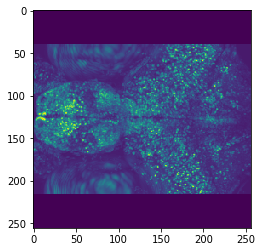

In [74]:
plt.imshow(scale_for_vid(mean_frame_T.numpy(), mymin, mymax))

In [31]:
del imaging